# Tutorial on automatic CNN optimization for spectral analysis: regression

This notebook is a companion of the article D. Passos and P. Mishra, "Automated optimization of deep spectral modelling for regression and classification: A tutorial", JOURNAL X, 2022.



The dataset used in this tutorial was first published in *N.T.Anderson, K.B.Walsh, J.R.Flynn, J.P.Walsh, Achieving robustness across season, location and cultivar for a NIRS model for intact mango fruit dry matter content. II. Local PLS and nonlinear models, Postharvest Biology and Technology, Volume 171, January 2021, 111358., and was slightly modified by applying a more stringent outlier removal procedure using T and Q2 analysis. 

The data is devided into train (2015, 2016, 2017 harvest seasons) and test (2018 harvest season).

The implementation of the Bayesian Optimization pipeline is the same used in *D. Passos, P. Mishra, An automated deep learning pipeline based on advanced optimisations for leveraging spectral classification modelling”, Chemometrics and Intelligent Laboratory Systems 215, (2021), 104354,* (https://doi.org/10.1016/j.chemolab.2021.104354). It combines TPE and Hyperband algorithms for Neural Architecture search and hyperparameter optimization using the Optuna package. Learning Rate is optimized separately using a LR range test.

This tutorial was created using following main packages versions:<br>
<br>
Tensorflow  2.5.0 <br>
Tensorflow add-ons  0.13.0 <br>
tqdm  4.46.0 <br>
Numpy  1.19.5 <br>
Pandas 1.1.0 <br>
Optuna  2.9.1 <br>

## 1) Import libraries
In this first step we import all the main libraries that will be used throughout this tutorial

In [1]:
## Readjust cell width in Jupyter 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
from sys import stdout
import logging

import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from IPython.display import clear_output

import scipy.io as sio
from scipy.signal import savgol_filter
import tqdm

from sklearn.preprocessing import StandardScaler 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score , KFold
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback,  ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa

## Use liveslossplot for training visualization in real time
from livelossplot import PlotLossesKerasTF

import optuna

This tutorial assumes that you have installed the correct versions of the main packages used: Tensorflow, Optuna, Scikit-Learn, Pandas and Numpy:<br>
+ TF version =  2.5.0
+ Optuna version =  2.9.1
+ Scikit-Learn version =  0.23.1
+ Pandas version =  1.1.0
+ Numpy version =  1.19.5

In [2]:
## Check for version of packages
print('Tensorflow ', tf.__version__)
print('Tensorflow add-ons ', tfa.__version__)
print('tqdm ', tqdm.__version__)
print('Numpy ', np.__version__)
print('Pandas', pd.__version__)
print('Optuna ', optuna.__version__)
# print('livelossplot ', livelossplot.__version__)

Tensorflow  2.5.0
Tensorflow add-ons  0.13.0
tqdm  4.46.0
Numpy  1.19.5
Pandas 1.1.0
Optuna  2.9.1


## 2) Help functions
In this section we implement a series of help functions that will be used during the optimization procedure. Run every cell once to ensure that all help functions are loaded.

Function that sets python's and TF random variable's seed to a specified value. This is important if one wants to be able to produce reproducible results.

In [3]:
## Define random seeds ir order to maintain reproducible results through multiple testing phases
def reproducible_comp():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
reproducible_comp()

Axiliary function to compute error metrics and make prediction plots

In [4]:
## Function to compute metrics and make prediction plots
def plot_prediction(X_calib, Y_calib, X_valid, Y_valid, X_test, Y_test, Y_calib_pred, Y_valid_pred, Y_test_pred, savefig=False, figname=None):
    
    ## Compute train error scores 
    score_p0 = r2_score(Y_calib, Y_calib_pred)
    mse_p0 = mean_squared_error(Y_calib, Y_calib_pred)
    rmse_p0 = np.sqrt(mse_p0)
    
    ## Compute valid error scores
    score_p1 = r2_score(Y_valid, Y_valid_pred)
    mse_p1 = mean_squared_error(Y_valid, Y_valid_pred)
    rmse_p1 = np.sqrt(mse_p1)
        
    ## Compute test error scores 
    score_p2 = r2_score(Y_test, Y_test_pred)
    mse_p2 = mean_squared_error(Y_test, Y_test_pred)
    rmse_p2 = np.sqrt(mse_p2)

  
    print('ERROR METRICS: \t TRAIN \t\t VALID \t\t TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f \t\t %5.3f \t\t %5.3f'  % (score_p0, score_p1, score_p2 ))
    print('RMSE: \t\t %5.3f \t\t %5.3f \t\t %5.3f' % (rmse_p0, rmse_p1,  rmse_p2))
    
 
    ## Plot regression for PLS predicted data
    rangey = max(Y_test) - min(Y_test)
    rangex = max(Y_test_pred) - min(Y_test_pred)

    fig=plt.figure(figsize=(6,6))
    z = np.polyfit(np.ravel(Y_test), np.ravel(Y_test_pred), 1)
    ax = plt.subplot(aspect=1)
    ax.scatter(Y_test,Y_test_pred,c='k',marker='o',s=20, alpha=0.6)
    ax.plot(Y_test, z[1]+z[0]*Y_test, c='blue', linewidth=2,label='linear fit')
    ax.plot(Y_test, Y_test, 'k--', linewidth=1.5, label='y=x')
    plt.ylabel('Predicted DM')
    plt.xlabel('Measured DM')
    plt.title('Prediction from CNN')
    plt.legend(loc=4)

    
    # Print the scores on the plot
    plt.text(min(Y_test_pred)+0.02*rangex, max(Y_test)-0.1*rangey, 'R$^{2}=$ %5.3f'  % score_p2)
    plt.text(min(Y_test_pred)+0.02*rangex, max(Y_test)-0.15*rangey, 'RMSE: %5.3f' % rmse_p2)
    if savefig==True:
        plt.savefig(figname, dpi=96)
        print('Figure saved')
    else:    
        plt.show() 
    return 

The next functions are used in the Learning Rate Finder section ahead

In [5]:
## Source / credit: 
#  https://www.kaggle.com/avanwyk/tf2-super-convergence-with-the-1cycle-policy
#  https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/

## Functions to implement the LR scheduler using OneCycleScheduler

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """`Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')
        
class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 1000, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(8,6))
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses, lw=2)  

Set parameters for graphics formating

In [16]:
## Graphics settings
## Setting the font sizes for comming figures
# plt.style.use("default")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

## uncomment for Latex graphics formating
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.sans-serif": ["Times"]})

# plt.rc('text', usetex=True)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 3) Data wrangling

### 3.1) Mango spectra dataset (with extra outliers removed on the train set)

Read the data (matlab format) using the scipy.io module 

In [6]:
data = sio.loadmat('mango_dm_full_outlier_removed2.MAT')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'DM_cal', 'DM_test', 'Sp_cal', 'Sp_test', 'wave', 'SP_all_test', 'SP_all_train'])


'DM_cal' and 'DM_test' correspond to the dry matter content of the training and test sets. This will be the Y variable that we want to predict.'Sp_cal' and 'Sp_test' contain the original spectral data. For convenience we provide 'SP_all_test' and 'SP_all_train' that contain an augmented version of those data by concatenating spectra, SNV, 1st deriv, 2nd deriv, SNV+1st deriv and SNV+2nd deriv. Lets take a quick look at the data: 

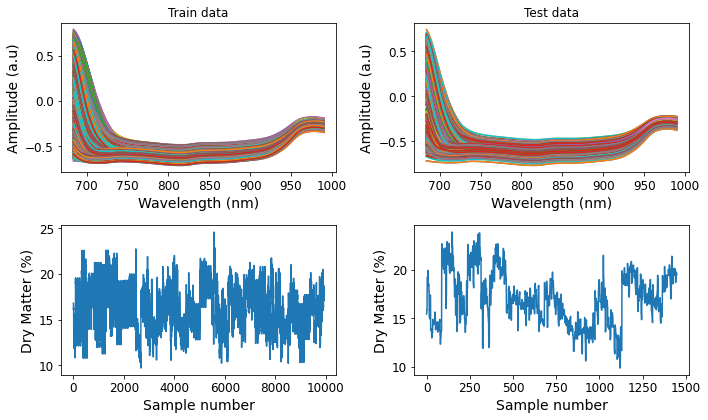

In [17]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.title('Train data')
plt.plot(data['wave'].T,data['Sp_cal'].T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Wavelength (nm)')
plt.subplot(222)
plt.title('Test data')
plt.plot(data['wave'].T,data['Sp_test'].T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Wavelength (nm)')
plt.subplot(223)
plt.plot(data['DM_cal'])
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.subplot(224)
plt.plot(data['DM_test'])
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.tight_layout()
plt.show()

We further split the training set into "calibration" and "tuning" subsets. This will be useful for the hyperparameter optimization of the models ahead.

In [8]:
## Spectra (x) and target variable (Y)

## Convert data type to float32 for better inter-operability with TensorFlow
x_train=data['SP_all_train'].astype(np.float32)
y_train=data['DM_cal'].astype(np.float32)
x_test=data['SP_all_test'].astype(np.float32)
y_test=data['DM_test'].astype(np.float32)

## Spliting the full train set into calib and tuning subsets. It is important to set the 'random_state'
## parameter to a fixed value in order to guarentee that each time you run the experiment, the data is
## split the same way
x_cal, x_tuning, y_cal, y_tuning = train_test_split(x_train, y_train, test_size=0.33, shuffle=True, random_state=42) 

## The wavelenghts for the XX axis when we plot the spectra
x_scale=data['wave'].astype(np.float32).reshape(-1,1)

## Check for dimensions
print('Data set dimensions ----------------------------')
print('Full Train set dims X Y = {}\t{}'.format(x_train.shape, y_train.shape))
print('Calibration set dims X Y = {}\t{}'.format(x_cal.shape, y_cal.shape))
print('Tuning set dims X Y = {}\t{}'.format(x_tuning.shape, y_tuning.shape))
print('Test set dims X Y = {}\t{}'.format(x_test.shape, y_test.shape))
print('wavelengths number = {}'.format(np.shape(x_scale)))

Data set dimensions ----------------------------
Full Train set dims X Y = (9914, 618)	(9914, 1)
Calibration set dims X Y = (6642, 618)	(6642, 1)
Tuning set dims X Y = (3272, 618)	(3272, 1)
Test set dims X Y = (1448, 618)	(1448, 1)
wavelengths number = (103, 1)


Just a couple of plots to check data consistency!!

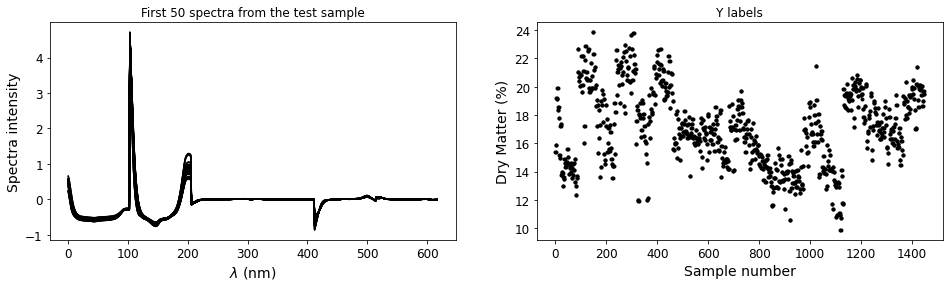

In [18]:
## Visual data sanity checking for the test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(x_test[:50,:].T,'k')
plt.title('First 50 spectra from the test sample')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Spectra intensity')
plt.subplot(1,2,2)
plt.title('Y labels')
plt.plot(y_test,'k.')
plt.xlabel('Sample number')
plt.ylabel('Dry Matter (%)')
plt.show()

In [42]:
np.min(y_test)

9.8670635

### 3.2) Data pre-prossessing for the Convolution Neural Network (CNN) model

Before we feed the spectral data to the CNN model, we standardize the data column-wise to put it in a range more useful to this type of algorithm.

In [19]:
## Since the test set is unknown (we are not suppose to have access to it during the
## optimization of the model) the scalling process should take this into account. We
## have to define a scaler based only on the train data, and apply it to the test data.

def standardize_column(X_train, X_calib, X_tuning, X_test):
    ## We train the scaler on the full train set and apply it to the other datasets
    scaler = StandardScaler().fit(X_train)
    ## for columns we fit the scaler to the train set and apply it to the test set
    X_calib_scaled = scaler.transform(X_calib)
    X_tuning_scaled = scaler.transform(X_tuning)
    X_test_scaled = scaler.transform(X_test)
    return [X_calib_scaled, X_tuning_scaled, X_test_scaled]

In [20]:
## Standardize on columns
x_cal_scaled_col, x_tuning_scaled_col, x_test_scaled_col = standardize_column(x_train, x_cal, x_tuning, x_test)

Just a quick look at the spectra data after standardization. We plot the test set

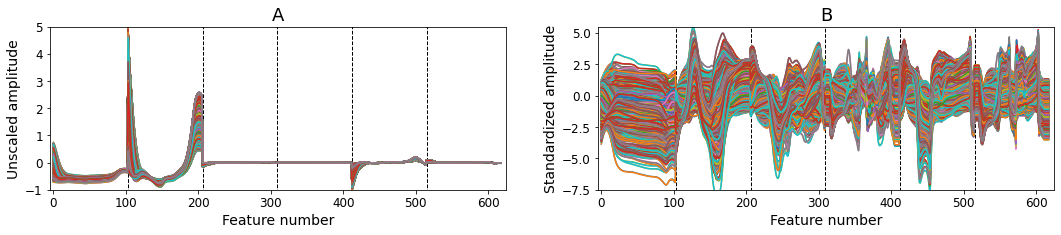

In [40]:
plt.figure(figsize=(18,3))
## left panel
plt.subplot(121)
plt.title('A', fontsize=18)
plt.plot(x_test.T)
plt.ylabel('Unscaled amplitude')
plt.xlabel('Feature number')
## vertical dashed lines separating the types of preprocessings that were concatenated
plt.vlines(np.arange(103,600,103), ymin=-1.1, ymax=5.1, color='k',ls='--',lw=1)
plt.xlim(-5,625)
plt.ylim(-1,5)

## right panel
plt.subplot(122)
plt.title('B', fontsize=18)
plt.plot(x_test_scaled_col.T)
plt.ylabel('Standardized amplitude')
plt.xlabel('Feature number')
plt.vlines(np.arange(103,600,103), ymin=-7.6, ymax=5.6, color='k',ls='--',lw=1)
plt.xlim(-5,625)
plt.ylim(-7.5,5.5)
plt.show()

## 4) 1D CNN model

The base CNN model is based on the proposals of Cui, Fearn 2018. It is composed by an input layer with the same size of the input data (as usual), followed by a Conv1d layer and 4 Fully Connected layers (FC). The number of units in the first FC layer is chosen to have 1/5 of the output of the conv.layers. The number of units in the following FC layers are dropped by a factor of 2, creating a funnel effect that constraints the NN to create higher level representations/abstractions of the input features.

The implementation of this model in tensorflow/keras is straightforward.<br> 
Some remarks before the implementation:
<br>

- **Weights initialization:**  "*The weights are initialized by a zero-mean Gaussian distribution whose standard deviation is $\sqrt{\frac{2}{n_i}}$, where $n_i$ is the number of input neurons*". This corresponds to <code>he_normal()</code> initializer in tf.keras.


- **Loss function:** The loss function proposed by *Cui, Fearn 2018* is $Loss = MSE + \frac{1}{2} \lambda \sum{w_i^2}$, i.e. the mean squared error (MSE) plus an L2 penalty $\lambda$ on the weights $w_i$. This is implemented by adding L2 regularization to the default MSE loss. Using Keras this is done by choosing the loss function as <code>'mse'</code> and apply an L2 regularization to the weights (by using <code> tf.keras.regularizers.l2(beta))</code>. The regularization hyperparameter $\lambda$ mentioned in the Cui, Fearn 2018 is related to keras $\beta$ as $\beta=\frac{\lambda}{2}$ (see [tf.keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2)). 


- **Optimizer:** We use the 'Adam' optimizer here, due to its proven record of good performance.

### 4.1) Model definition

In [43]:
## Make sure computations are reproducible
reproducible_comp()

## This function initializes the model as a function of filter size and L2. regularization strength 
def init_model(filter_size, reg_beta):
    ## define the input layer dimensions
    INPUT_DIMS = np.shape(x_cal)[1]
    ## conv layer dimensions
    CONV1D_DIMS = INPUT_DIMS
    ## number of kernels (a.k.a. filters)
    K_NUMBER = 1
    ## kernel width
    K_WIDTH = filter_size
    ## kernel stride
    K_STRIDE = 1
    ## Number of neurons on first FC layer
    FC1_DIMS = 128
    ## Number of neurons on second FC layer
    FC2_DIMS = 64
    ## Number of neurons on third FC layer
    FC3_DIMS = 16
    ## Number of neurons on final FC layer
    OUT_DIMS = 1

    ## L2 regularizer parameter
    beta= reg_beta/2.

    ## For the sake of simplicity we do the weights initialization for multiple layers here
    ## Setting he_normal(seed = cte) ensures that everytime the CNN is initialized, it has the same weights configuration.
    ## This is important for reproducibility but can be detrimental for robustness.
    K_INIT = tf.keras.initializers.he_normal(seed=123)

    ## Weights L2 regularization 
    K_REG = tf.keras.regularizers.l2(beta)

    ## The CNN is implemented as a sequence of layers using keras.Sequential()
    model_cnn = keras.Sequential([  keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,)), \
                                keras.layers.Conv1D(filters=K_NUMBER, \
                                                    kernel_size=K_WIDTH, \
                                                    strides=K_STRIDE, \
                                                    padding='same', \
                                                    kernel_initializer=K_INIT,\
                                                    kernel_regularizer=K_REG,\
                                                    activation='elu',\
                                                    input_shape=(CONV1D_DIMS,1)), \
                                keras.layers.Flatten(),
                                keras.layers.Dense(FC1_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu'),
                                keras.layers.Dense(FC2_DIMS, \
                                                   kernel_initializer=K_INIT,\
                                                   kernel_regularizer=K_REG,\
                                                   activation='elu'),
                                keras.layers.Dense(FC3_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu'),
                                keras.layers.Dense(1, kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG,\
                                                   activation='linear'),
                              ])

    return(model_cnn)

We can view all the parameters involved in this model and plot its structure to have a better intuition of it

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 618, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 618, 1)            6         
_________________________________________________________________
flatten (Flatten)            (None, 618)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               79232     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

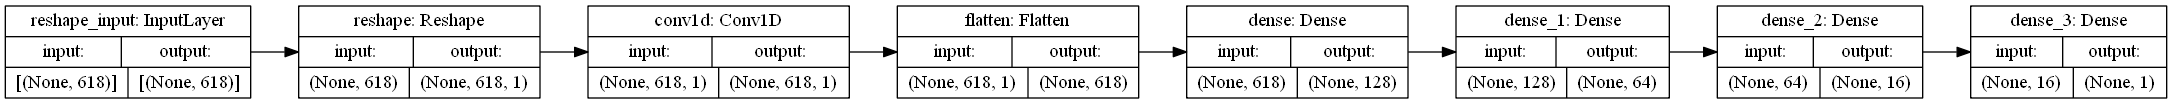

In [44]:
## Initialize a new CNN with a filter size of 5 points and L2 reg. = 0.0006 (weak regularization)
model_cnn = init_model(5, 0.0006)

## Print the summary of the model
print(model_cnn.summary())

## Plot the architecture of the CNN
plot_model(model_cnn,  to_file='mode_cnn.png', show_shapes=True, show_layer_names=True, \
           rankdir='LR', expand_nested=False, dpi=96)

### 4.2) Non-optimized train and prediction

Here we use some default values for hyperparameters, train the CNN for 450 epochs and finally make a prediction on our test set.

Practical note: if you get error messages associated with "permission errors", check if your files are being sync by some app like OneDrive or Dropbox. 

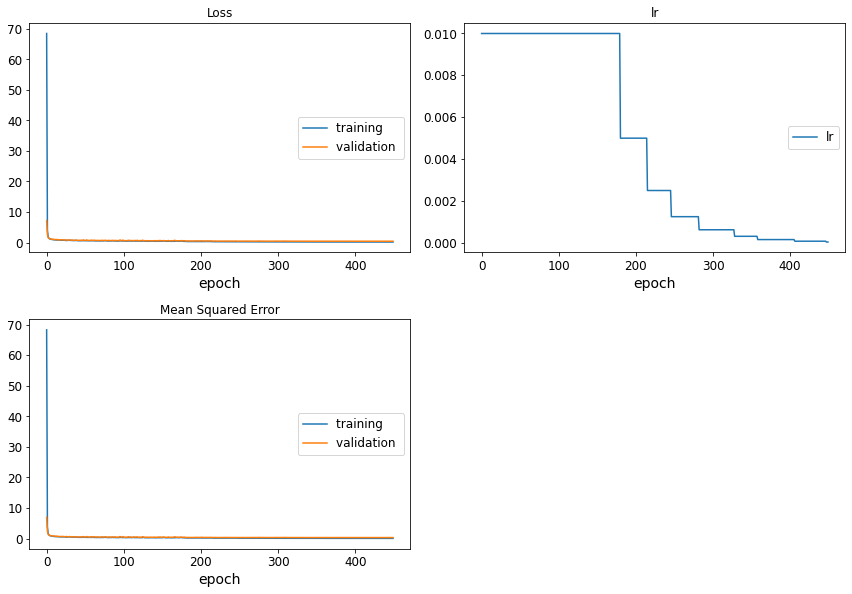

Loss
	training         	 (min:    0.155, max:   68.481, cur:    0.155)
	validation       	 (min:    0.418, max:    7.186, cur:    0.419)
lr
	lr               	 (min:    0.000, max:    0.010, cur:    0.000)
Mean Squared Error
	training         	 (min:    0.066, max:   68.322, cur:    0.066)
	validation       	 (min:    0.327, max:    7.003, cur:    0.330)


In [46]:
## Run this base model once to see if its training correctly
## This can be viewed as a baseline that hyperparameter optimization should improve

tf.keras.backend.clear_session()

## Define the batch size (number of sample to train for each pass into the CNN)
BATCH = 256
## Define the filter size
FILTER_SIZE = 5
## Define the L2 reg.
L2_BETA = 0.0006

## initialize the model
model_cnn=init_model(FILTER_SIZE, L2_BETA)
  
##### TRAIN MODEL WITH ADAM OPTIMIZER #########

## Heuristic that sets the learning rate 
LR=0.01*BATCH/256.
print('Adam learning rate = {}'.format(LR))

## Define the model name for saving purposes
MODEL_NAME = 'base_model.h5'

## Compile the model defining the optimizer, the loss function and the metrics to track during training
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse', metrics=['mse'])  

## The following are several callbacks that can be used during training to improve its efficiency and decrease overfit
## 1) Stop the training if it does not improve
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=50, mode='auto', restore_best_weights=True)

## 2) Reduce learning rate dynamically
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)

## 3) Save the best weights into file
checkpointer = ModelCheckpoint(filepath=MODEL_NAME, verbose=1, save_best_only=True)

## 4) Visualize tracked metrics in real time during training
plot_losses = PlotLossesKerasTF()


## Train the model for 500 epochs on the x_cal data while monitoring the models performance on the x_tuning data.
## The data in the tuning set is not used for actial training. It is only used to measure model performance.
h1 = model_cnn.fit(x_cal_scaled_col, y_cal, batch_size=BATCH, epochs=450, \
      validation_data=(x_tuning_scaled_col, y_tuning),  \
      callbacks=[checkpointer, rdlr, early_stop, plot_losses],verbose=1)

## Clear the session. This is important to ensure that on the next training session, the weights are properly initialized.
## On the other hand if one need to continue a training session for longer, this can just be commented.
tf.keras.backend.clear_session()

The training of the CNN was saved into the history object "h1". In case of the plot_losses callback didn't work properly (or you had trouble installing it), the "plot_losses" can be removed from the list of callbacks and instead the training process can be plotted using h1.

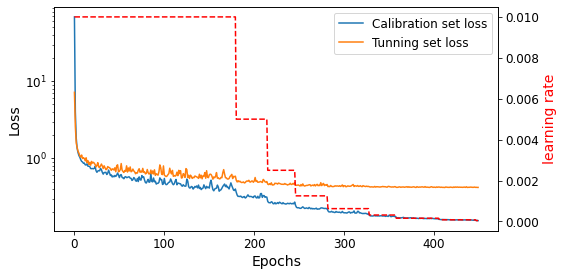

In [51]:
## If you used Livelossplot, you can skip this. Otherwise we can take a look at the training process by plotting the
## models history.
plt.figure(figsize=(8,4))
plt.plot(h1.history['loss'], label='Calibration set loss')
plt.plot(h1.history['val_loss'], label='Tunning set loss')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
# plt.ylim(0.5,1)
plt.legend()
## In case you used ReduceLROnPlateau() you can plot the lr as well
ax2 = plt.gca().twinx()
ax2.plot(h1.history['lr'], color='r', ls='--')
ax2.set_ylabel('learning rate',color='r')
plt.tight_layout()
plt.show()
# plt.savefig('train_tun_loss.png', dpi=96)

The above figure shows how the 'mse' (mean square error) is dropping during a training session, for the calibration data (blue) and for the tuning data (orange). The red stepwise line shows how the Learning Rate is being dynamically adjusted during training by the ReduceLROnPlateau() callback. In this case, the training process continued for the full 450 epochs. However, since we used the earlystop callback, it could have stopped earlier if the model improvement was below the set threshold.

Since we are now in possession of a trained CNN we can see how this model fairs in the test data. During training, the best weights configurations were being monitored by the checkpointer callback that save those weights to an .h5 file. The fist step then is to reload those best weights into our model and apply it to the test set for final predictions. We will use the plot_prediction function we defined in the beginning of the notebook.

ERROR METRICS: 	 TRAIN 		 VALID 		 TEST
------------------------------------------------------
R2: 		 0.988 		 0.943 		 0.840
RMSE: 		 0.259 		 0.572 		 1.068


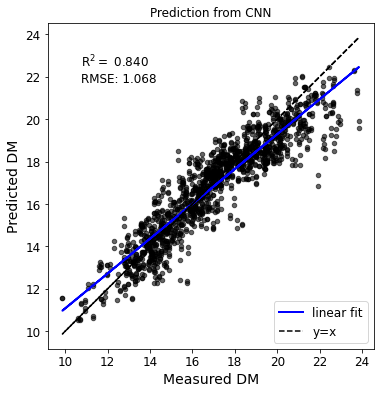

In [53]:
## Initialize a new model if needed
# model_cnn=init_model(5, 0.0003)

## load pre-computed model weights into model_cnn
model_cnn.load_weights("base_model.h5")

## Compute metrics for CAL, TUNING and TEST sets
y_cal_pred1 = model_cnn.predict(x_cal_scaled_col)
y_tuning_pred1 = model_cnn.predict(x_tuning_scaled_col)
y_test_pred1  = model_cnn.predict(x_test_scaled_col)

## Plot the prediction. For this case the TRAIN column on the output corresponds to the tuning set
plot_prediction(x_cal_scaled_col, y_cal, x_tuning_scaled_col, y_tuning, x_test_scaled_col, y_test, \
                y_cal_pred1, y_tuning_pred1, y_test_pred1, savefig=False, figname='prediction_base_model.png')

## 5) CNN Optimization

Now that we know how to define a CNN model, training it and make predictions, we will proceed to see how can we optimize it in order to extract more performance from it. The following pipeline allows to optimize the convolutional filter width (<code>FILTER_SIZE</code>) and the strength of the L2 regularization(<code>L2_BETA</code>). These hyperparameters are needed to define the model itself. There are also two other hyperparameter that will be optimized, the training batch size (<code>BATCH</code>) and the Adam() learning rate (<code>LR</code>)  that is related to the training process itself. 

In case of need and depending on the computational resources available, the range of optimization could easily be extended to more hyperparameters such as the number of filters in the conv. layer, the number of conv. layers, etc... 

In [54]:
## Make computations reproducible
reproducible_comp()

## Define the model
def create_model(filter_size, reg_beta):
    ## dimensions of the input layer
    INPUT_DIMS = np.shape(x_cal)[1]
    ## dimensions of the conv. layer
    CONV1D_DIMS = INPUT_DIMS
    ## number of filters/kernels in the conv. layer
    K_NUMBER = 1
    ## filter width to be optimized
    K_WIDTH = filter_size
    ## size of the filter stride during the conv. operation 
    K_STRIDE = 1
    ## number of units in the first dense layer
    FC1_DIMS = 128
    ## number of units in the second dense layer
    FC2_DIMS = 64
    ## number of units in the third dense layer
    FC3_DIMS = 16
    ## number of units output layer
    OUT_DIMS = 1

    ## L2 regularizer parameter to be optimized
    beta= reg_beta/2.

    ## For the sake of simplicity we do the weights initialization for multiple layers here
    ## Setting he_normal(seed = cte) ensures that everytime the CNN is initialized, it has the same weights configuration.
    ## This is important for reproducibility but can be detrimental for robustness.
    K_INIT = tf.keras.initializers.he_normal(seed=123) # See what happens whem you try a different seed, e.g. 9152!

    ## Weights L2 regularization 
    K_REG = tf.keras.regularizers.l2(beta)

    ## The CNN is implemented as a sequence of layers using keras.Sequential()
    model_cnn = keras.Sequential([  keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,), \
                                                         name='RESHAPE'), \
                                keras.layers.Conv1D(filters=K_NUMBER, \
                                                    kernel_size=K_WIDTH, \
                                                    strides=K_STRIDE, \
                                                    padding='same', \
                                                    kernel_initializer=K_INIT,\
                                                    kernel_regularizer=K_REG,\
                                                    activation='elu',\
                                                    input_shape=(CONV1D_DIMS,1),\
                                                    name='CONVOLUTIONAL'), \
                                keras.layers.Flatten(name='FLATTEN'),
                                keras.layers.Dense(FC1_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu',\
                                                   name='FC1'),\
                                keras.layers.Dense(FC2_DIMS, \
                                                   kernel_initializer=K_INIT,\
                                                   kernel_regularizer=K_REG,\
                                                   activation='elu',\
                                                   name='FC2'),\
                                keras.layers.Dense(FC3_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu',\
                                                   name='FC3'),\
                                keras.layers.Dense(1, kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG,\
                                                   activation='linear',\
                                                   name='OUTPUT'),
                              ])

    return(model_cnn)

Again, like in the introduction of the tutorial, we can initialize the CNN model and a summary of its parameters. In this specific case, the <code>num_FC_units</code> is a list of size <code>num_FC_layers</code>. The dropout entry is also a list of the same size with the dropout rate for each dropout layer. We just use this new structure and define the same number of layers, etc as previously done, just for comparison purposes.

In [55]:
model_cnn=create_model(5, 0.0006)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RESHAPE (Reshape)            (None, 618, 1)            0         
_________________________________________________________________
CONVOLUTIONAL (Conv1D)       (None, 618, 1)            6         
_________________________________________________________________
FLATTEN (Flatten)            (None, 618)               0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               79232     
_________________________________________________________________
FC2 (Dense)                  (None, 64)                8256      
_________________________________________________________________
FC3 (Dense)                  (None, 16)                1040      
_________________________________________________________________
OUTPUT (Dense)               (None, 1)                 1

Note: Each time a model is trained, even using the same hyperparameters, etc. the results might be slightly different due to the stochastic gradient descent algorithm. This is expected to happen, specially if you are running Tensorflow in a GPU. The GPU version of Tensorflow relies on the parallelization capabilities of NVidia's CUDA library that can introduce some stochasticity to the process. If very high precision and reproducibility are required, the models can be trained sequentially (deterministically) on the CPU, with the trade-off of a higher computation time. Nonetheless, for a relatively model and input data like the ones used in this tutorial, the GPU gain might not be to visible.

### 5.1) Optimization for the Learning Rate hyperparameter

Arguably one of the most important hyperparameters in NN models is the Learning Rate (LR). This hyperparameter has a large impact in the velocity your model trains and in its stability/convergence. Usually the default LR that comes predefined in optimizer algorithm tends to work ok but its far from optimal. There are some works that highlight the interplay / interdependence between LR and Batch size which makes the heuristic used earlier  <code>(LR = 0.01*BATCH/256) </code> work well. However this rule of thumb was developed through intuition and works around 2D CNNs applied to image analysis and is not guaranteed to perform similarly well with 1d spectral data. 

The learning rate range finder test allows to have a notion of what learning rates work well for the data and CNN architecture we are using. The idea behind the LR finder is that we can train a model with a incrementally changing LR and then check for the interval (range) where stable solutions are obtained. We use the LRFinder function defined in the Help Functions section at the beginning of the notebook. 

One of the assumptions that is done here is that the LR is more dependent on the data type and LR range the obtained through this range test using the base CNN architecture is not much different from the final optimized architecture. Usually this assumption can be checked in the end of the optimization process by repeating this LRFinder test with the optimal CNN architecture.

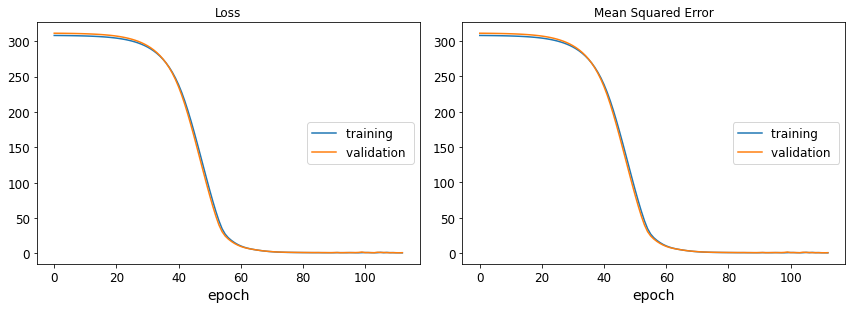

Loss
	training         	 (min:    0.627, max:  308.080, cur:    0.627)
	validation       	 (min:    0.702, max:  311.244, cur:    0.810)
Mean Squared Error
	training         	 (min:    0.492, max:  307.953, cur:    0.492)
	validation       	 (min:    0.567, max:  311.117, cur:    0.675)


In [56]:
## Max training epochs
EPOCHS = 450
## Batch size
BATCH = 256

## number of steps 
step_base=0.25*np.ceil(len(x_cal_scaled_col) / BATCH) * EPOCHS
print('Optimizing LR for {} steps'.format(step_base))

## Start with a small LR = 1e-8 to ensure convergence and progressively increase LR until end_lr. 
## The smoothing factor help smooth out the mse during training. You can experiment with these values to see what happens to the loss curve... 
lr_finder_base = LRFinder(start_lr= 1e-8, end_lr = 0.1, max_steps= step_base, smoothing=0.9)

# MODEL_NAME='base_model.h5'

## clear the session
tf.keras.backend.clear_session()

## initialize the model
model = create_model(5, 0.0006)
## compitle the model
model.compile(optimizer=keras.optimizers.Adam(),loss='mse',metrics=['mse']) 

## Callback to visualize the training
plot_losses = PlotLossesKerasTF()

## Train the model using lr_finder_base as LR scheduler in the callback list
h3 = model.fit(x_cal_scaled_col, y_cal, batch_size = BATCH, epochs = EPOCHS, \
              validation_data=(x_tuning_scaled_col, y_tuning),  \
              callbacks=[lr_finder_base, PlotLossesKerasTF()],verbose=1)  


From the previous figures we can see that in the beginning of the training process, when the LR is very small, the model doesn't actually learning anything. This correspond to the mse plateau between epochs 0 and 35. Only between epochs ~40 and 60 there is a visible improvement of the mse (the model is learning something). After epoch ~65 the performance plateaus again. This is more clear by plotting 'mse-loss' vs LR instead of 'mse loss' vs epoch. We can apply the method .plot() previously defined in LRFinder() to see this.

(1e-08, 0.04)

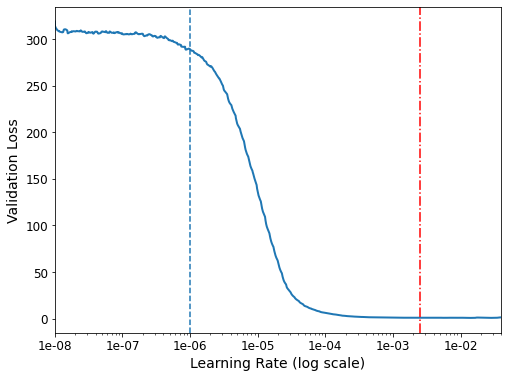

In [59]:
lr_finder_base.plot()
plt.axvline(1e-6, ls='dashed')
plt.axvline(0.0025, ls='dashdot', color='r')
plt.ylabel('Validation Loss')
plt.xlim(1e-8, 4e-2)

The blue dashed line marks the LR at which our model starts to learn something. For lower LR, this test indicates that the model doesn't improve. With this in mind the LR = 1e-5 is chosen as a lower limit for LR. On the other hand, the red dashed line, sits in the middle of the region where larger LR also don't contribute to the improvement of the model (i.e. the loss is basically constant). A LR = 0.0025 is chosen as the max LR allowed. A larger LR could lead to faster training processes but at the risk of the model to become unstable and never actually converge to a minimum or even leading to "gradient explosions". You can try and set the end_lr in the previous cell to a higher value (e.g. 0.9) and you will see that most likely the training process will blow up (sharp upward peak at the end of training).

For example we could choose one of the values in this range (preferably around 1e-4) as a fixed LR during the whole training. However, our current model implementation takes advantage of the ReduceLRonPlateau() callback that allow to dynamically decrease LR to improve the optimizer's convergence. Therefore, we set the min LR that ReduceLRonPlateau() allows as the lower LR found with the LRFinder test and the initial Adam LR as the max LR found with the LRFinder test. This allows for an initial fast convergence of the model (large LR) and when needed it can be decreased by ReduceLRonPlateau() to improve convergence on a minima. 

### 5.2) Bayesian Optimization (BO) of the hyperparameters.

We have finally arrived to the section of the notebook where we use a Bayesian optimization method to find the optimal hyperparameters for our model. More than finding the optimal hyperparameters, this pipeline also allows for a restricted Neural Architecture Search (NAS). Remember that we are also testing for slightly different NAS by probing different number of FC layers and dropout layers. These are not hyperparameters *per se*, but instead are characteristics of the neural network architecture itself. In the example we present here we restrict the NAS to a small number of FC (2 to 5) and dropout layers. However, depending on the available computational resources, the reader could expand this NAS to a higher search space with different types of layers (eg. multiple conv. layers, bach normalization layers, etc.) in order to be able to explore much more complex architectures. 

NOTE: From experience we can say that there are some consideration to take care when performing this type of automated approach. If one allows a very shallow architecture (e.g. just 1 FC layer) with a large number of units (e.g. very wide), there is a tendency for this automated NAS method to procure this type of solutions instead of deeper architectures. This goes in hand with the empirical evidence that shallow but wide neural networks are more prone to "memorize" the dataset and have less generalization capacities than deeper networks. One should be aware of these caveats/limitations when setting up the NAS space. 

The method of BO that we apply is called Tree Parzen Estimator (TPE) associated with a pruning method (Hyperband). While TPE looks for the best values of hyperparameters according to distribution functions and Bayes rules, the Hyperband algorithm improves the pipeline speed by discarding less promising trials (made by using less favorable combinations of the hyperparameter space). The hyperband algorithm trains models defined using multiple combinations of hyperparameters for a few epochs, discards the less promising, and resumes training on the most promising ones.

There are a few python (and Matlab) libraries that simplify this kind of BO task, but we choose the Optuna library due to its versatility, documentation and easy of use. 

In [15]:
## We start by calling a callback that allows for hyperband to "talk" to keras and terminate/resume training
from optuna.integration import TFKerasPruningCallback

## Set the path where the computed models are saved
path='optuna_models\\'

## list for additional metrics
metricas=[]

## Callbacks to use during training
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=50, mode='auto', restore_best_weights=True)  
## Note that the min_lr in rdlr is the one found in the LRFinder test

rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

## This callback draws small progress bar in the screen for each training session. Its useful to check the progress of the task
progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

## Subclass ModelCheckpoint -  Custom ModelCheckpoint to save models only after a certain number of epochs (to save resources)
## This is a custom version of the ModelCheckpoint() callback that only saves the best models if they are trained for more than 150 epochs
## By using this, the less promising models that hyperband will discard, are not saved to disk. This leads to less saved models in the disk.
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super(CustomModelCheckpoint, self).__init__(*args, **kwargs)

    ## redefine the save so it only activates after 150 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 150: super(CustomModelCheckpoint, self).on_epoch_end(epoch, logs)


## Define the objective function to monitor during optimization, set the hyperperameters ranges, etc.
## In this section we define the most important part of the optimization process, i.e, the objective function or value that our 
## BO will try to minimise. In this function we define all the hyperparamters intervals or search space that will be used in 
## the optimization. 
def objective(trial):
    
    ## Clear clutter from previous session   
    keras.backend.clear_session()
    
    ## define the model/study name. In this case we will save a model with the same name of its trial
    ## Remember, one trial is training a model with a specific set of hyperparameters
    MODEL_NAME='study_trial='+str(trial.number)+'.h5' 
    
    ## In the follow steps we define the search space for each of the hyperparameters. This is done by using
    ## distributions/intervals of integers or floats from a min, to a max with a certain step.
        
    ## filter size  (K_WIDTH)
    FILTER_SIZE = int(trial.suggest_int("filter_size", 5, 51, step = 2)) 
    
    ## L2 regularization
    REG_BETA = trial.suggest_float("reg_beta", 0., 0.05, step=0.0005)
    
    ## Instantiate the model with values samples from the previous defined intervals
    model = create_model(FILTER_SIZE, REG_BETA)
    
    ## Add batch size to the hyperparameters to be optimized. This hyperparameter is not used directly by the model
    ## but is used in the training phase.
    
    BATCH_SIZE = int(trial.suggest_int("batch_size", 64, 256, step = 64))
    ## Add batch size to the parameters that Optuna logs
    trial.set_user_attr("batch_size", BATCH_SIZE)
    
    ## Initial LR for Adam optimizer corresponding to the max LR chosen in the LRFinder test
    LR=0.0025  
    
    ## Alternatively we could set the initial LR using the previously mentioned heuristic as a function of BATCH_SIZE
    # 0.01*BATCH_SIZE/256.
    
    ## Compile the model, use Adam() as optimizer, and mse as loss function
    ## Note: the learning_rate in Adam() is set to the max LR found in the LRFinder test
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
          loss="mse",
          metrics=["mse"])
        
    ## Callbacks
    custom_checkpointer= CustomModelCheckpoint(filepath=path+MODEL_NAME, verbose=0, save_best_only=True)  
    ## Alternatively we could save all models using the default ModelCheckpoint()  
    # checkpointer= keras.callbacks.ModelCheckpoint(filepath=path+MODEL_NAME, verbose=1, save_best_only=True)
    
    
    ## Train the model on train data and validate it on tuning (val) data
    ## Note: The callback TFKerasPruningCallback(trial, 'val_loss') is necessary to convey val_loss info to the Hyperband pruner
    history = model.fit(x_cal_scaled_col, y_cal, batch_size = BATCH_SIZE, epochs = 450, \
                        validation_data = (x_tuning_scaled_col, y_tuning), \
                        callbacks=[rdlr, early_stop, custom_checkpointer, TFKerasPruningCallback(trial, 'val_loss'), progressbar], \
                        verbose=0)
    
    ## Compute auxiliary metrics
    scores_cal = model.evaluate(x_cal_scaled_col, y_cal, verbose=0)
    print('Calibration rmse={}'.format(np.sqrt(scores_cal[1])))
       
    scores_tuning = model.evaluate(x_tuning_scaled_col, y_tuning, verbose=0) 
    print('Tuning rmse={}'.format(np.sqrt(scores_tuning[1])))
    
    ## Append each trial's hyperparameters and scores into a list for later analysis 
    metricas.append([MODEL_NAME, FILTER_SIZE, REG_BETA, BATCH_SIZE, \
                     np.sqrt(scores_cal[1]), np.sqrt(scores_tuning[1]) ])
    
    ## The metric we want to minimize. In this case we are chosing the RMSE of the tuning set.
    return 0.5*np.sqrt(scores_tuning[1]) + 0.5*(np.abs(scores_tuning[1] - scores_cal[1]))

In the <code>objective(trial)</code> function we defined our model, the hyperparameters ranges that will be explored by the BO and the objective function we want to minimize. We chose a single objective function that in this case is the root mean squared error (RMSE) on the tuning set. This objective function could be more complex and elaborated if needed. For example we could define as objective function the minimization of $Objective = RMSE_{tuning} - RMSE_{cal}$, to account for less overfitting, or even a weighted sum of $Objective = w_1 RMSE_{tuning} + w_2 (RMSE_{tuning} - RMSE_{cal})$, that enforces the model to generalize better (looking for low tuning RMSE) and avoid overfit (by minimizing the difference between calib and tuning RMSE). In case of need, for some specific cases, Optuna also allows for the definition of multiple objective functions.

In the next cell we define a study object that takes into account the objective, the type of optimization (minimization or maximization), the algorithm of choice, the number of trials, the pruner algorithm, etc. In the end of the cell we instantiate the optimization of this study, and the optimization process starts. Depending on the computational resources, model type, data size, number of trials, etc. this process can take from hours to days. In what follows, for the purpose of this tutorial we optimize the model for 200 trials with the prior knowledge that this is a small number of trials for the hyperparameter space we have defined. For this specific model, trial and error showed that 1000 to 1500 trials would be required to really probe the hyperparameter space more evenly.

One of the things to have in mind in that in the TPEsampler algorithm starts by randomly probe the hyperparameters space in the first n_startup_trials (effectively equivalent to a random grid search) to ensure exploration and only after that number of trials, it starts to use the TPE algorithm to exploit the most promising directions. That being said, it is recommended that we start with a large enough n_startup_trials (to ensure exploration) and use a much larger number of trials to improve exploitation.

In a modest PC (e.g. Intel Core i7 4790k, 16Gb RAM and a NVidia RTX 2080 Ti) these 500 trials should take about 14h 5min.
For convenience, we also share the a precomputed study object that has the results of on optimization round.

In [16]:
## Enable Optuna logger (for tracking purposes) 
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

## Unique identifier of the study
study_name = "study"  

## Name of the SQL data base where optuna saves the trials, values, etc... 
## The optimization and logs the results into a database .db file that can be monitored in real time with the optuna-dashboard
storage_name = "sqlite:///{}.db".format(study_name)

## Create a study that will, in this case minimize the objective function previously defined
## We use TPE with a cte seed (for reproducibility) and n_startup_trials = 66 (random search picks) to 
## warm up the BO. In this study we also enable multivariate = True in order for the TPE alg. to look for
## relatioships between hyperparameters (it creates multivariate kernel densities instead of single kernel
## densities). The multivariate option is still experimental in optuna 2.8 but our in-house test seem to favor it.
## Pruning is done with the HyperBand algorithm and we allocate a min_resource of 50 epochs
## per model to guarantee that the convergence level is high enough to ensure reliable solutions before the
## hyperband to act as pruner.
study = optuna.create_study(study_name=study_name, \
                            storage=storage_name,  \
                            direction='minimize',  \
                            sampler = optuna.samplers.TPESampler(seed = 123, 
                                                                 consider_endpoints = True, 
                                                                 multivariate = True,
                                                                 n_startup_trials = 50),\
                             pruner=optuna.pruners.HyperbandPruner(min_resource=50, reduction_factor=4),\
                             load_if_exists=True)

## In the case that we have already found (by trial and error) some nice hyperparameters, we can 
## enqueue them into the hyperparameter search space. This way the pruner will be more effective
## because the search will start from an already good solution (relatively low rmse in this case).
## For example we might want to enque the hyperparameter values that we used for our base cnn.
study.enqueue_trial({ "filter_size":5,
                      "reg_beta":0.003,
                      "batch_size":256,
                       })

## Start optimization with a budget of 500 trials
study.optimize(objective, n_trials = 500)

[I 2021-07-16 11:39:57,663] A new study created in RDB with name: study


A new study created in RDB with name: study
A new study created in RDB with name: study


C:\Users\dmcp\Miniconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:35: ExperimentalWarning:

enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.




Epoch 00259: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00301: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00366: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00449: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.33445308655897
Tuning rmse=0.5876238905363274


[I 2021-07-16 11:41:42,013] Trial 0 finished with value: 0.4105334300782776 and parameters: {'filter_size': 5, 'reg_beta': 0.003, 'batch_size': 256}. Best is trial 0 with value: 0.4105334300782776.


Trial 0 finished with value: 0.4105334300782776 and parameters: {'filter_size': 5, 'reg_beta': 0.003, 'batch_size': 256}. Best is trial 0 with value: 0.4105334300782776.
Trial 0 finished with value: 0.4105334300782776 and parameters: {'filter_size': 5, 'reg_beta': 0.003, 'batch_size': 256}. Best is trial 0 with value: 0.4105334300782776.



Epoch 00139: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00249: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00407: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00443: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.5460558887721989
Tuning rmse=0.6219933191198227


[I 2021-07-16 11:46:44,559] Trial 1 finished with value: 0.35534598724336014 and parameters: {'filter_size': 37, 'reg_beta': 0.014, 'batch_size': 64}. Best is trial 1 with value: 0.35534598724336014.


Trial 1 finished with value: 0.35534598724336014 and parameters: {'filter_size': 37, 'reg_beta': 0.014, 'batch_size': 64}. Best is trial 1 with value: 0.35534598724336014.
Trial 1 finished with value: 0.35534598724336014 and parameters: {'filter_size': 37, 'reg_beta': 0.014, 'batch_size': 64}. Best is trial 1 with value: 0.35534598724336014.


[I 2021-07-16 11:47:04,551] Trial 2 pruned. Trial was pruned at epoch 50.


Trial 2 pruned. Trial was pruned at epoch 50.
Trial 2 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 11:47:24,073] Trial 3 pruned. Trial was pruned at epoch 50.


Trial 3 pruned. Trial was pruned at epoch 50.
Trial 3 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 11:47:38,675] Trial 4 pruned. Trial was pruned at epoch 50.


Trial 4 pruned. Trial was pruned at epoch 50.
Trial 4 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 11:47:57,859] Trial 5 pruned. Trial was pruned at epoch 50.


Trial 5 pruned. Trial was pruned at epoch 50.
Trial 5 pruned. Trial was pruned at epoch 50.



Epoch 00139: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 11:50:28,552] Trial 6 pruned. Trial was pruned at epoch 200.


Trial 6 pruned. Trial was pruned at epoch 200.
Trial 6 pruned. Trial was pruned at epoch 200.



Epoch 00218: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00271: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00342: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00379: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00443: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.5554456499449797
Tuning rmse=0.6235005033777036


[I 2021-07-16 11:52:51,446] Trial 7 finished with value: 0.3518667555235762 and parameters: {'filter_size': 29, 'reg_beta': 0.0265, 'batch_size': 192}. Best is trial 7 with value: 0.3518667555235762.


Trial 7 finished with value: 0.3518667555235762 and parameters: {'filter_size': 29, 'reg_beta': 0.0265, 'batch_size': 192}. Best is trial 7 with value: 0.3518667555235762.
Trial 7 finished with value: 0.3518667555235762 and parameters: {'filter_size': 29, 'reg_beta': 0.0265, 'batch_size': 192}. Best is trial 7 with value: 0.3518667555235762.


[I 2021-07-16 11:53:07,916] Trial 8 pruned. Trial was pruned at epoch 50.


Trial 8 pruned. Trial was pruned at epoch 50.
Trial 8 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 11:53:29,148] Trial 9 pruned. Trial was pruned at epoch 50.


Trial 9 pruned. Trial was pruned at epoch 50.
Trial 9 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 11:53:45,646] Trial 10 pruned. Trial was pruned at epoch 50.


Trial 10 pruned. Trial was pruned at epoch 50.
Trial 10 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 11:54:07,388] Trial 11 pruned. Trial was pruned at epoch 50.


Trial 11 pruned. Trial was pruned at epoch 50.
Trial 11 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 11:54:28,502] Trial 12 pruned. Trial was pruned at epoch 50.


Trial 12 pruned. Trial was pruned at epoch 50.
Trial 12 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 11:54:41,808] Trial 13 pruned. Trial was pruned at epoch 50.


Trial 13 pruned. Trial was pruned at epoch 50.
Trial 13 pruned. Trial was pruned at epoch 50.



Epoch 00178: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 11:57:16,133] Trial 14 pruned. Trial was pruned at epoch 200.


Trial 14 pruned. Trial was pruned at epoch 200.
Trial 14 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 11:57:30,182] Trial 15 pruned. Trial was pruned at epoch 50.


Trial 15 pruned. Trial was pruned at epoch 50.
Trial 15 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 11:57:43,642] Trial 16 pruned. Trial was pruned at epoch 50.


Trial 16 pruned. Trial was pruned at epoch 50.
Trial 16 pruned. Trial was pruned at epoch 50.



Epoch 00178: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 12:00:07,556] Trial 17 pruned. Trial was pruned at epoch 200.


Trial 17 pruned. Trial was pruned at epoch 200.
Trial 17 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 12:01:06,135] Trial 18 pruned. Trial was pruned at epoch 200.


Trial 18 pruned. Trial was pruned at epoch 200.
Trial 18 pruned. Trial was pruned at epoch 200.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00260: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00361: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.5271862501255091
Tuning rmse=0.6152544290816423


[I 2021-07-16 12:04:02,232] Trial 19 finished with value: 0.35793354963241203 and parameters: {'filter_size': 21, 'reg_beta': 0.015, 'batch_size': 128}. Best is trial 7 with value: 0.3518667555235762.


Trial 19 finished with value: 0.35793354963241203 and parameters: {'filter_size': 21, 'reg_beta': 0.015, 'batch_size': 128}. Best is trial 7 with value: 0.3518667555235762.
Trial 19 finished with value: 0.35793354963241203 and parameters: {'filter_size': 21, 'reg_beta': 0.015, 'batch_size': 128}. Best is trial 7 with value: 0.3518667555235762.


[I 2021-07-16 12:04:17,034] Trial 20 pruned. Trial was pruned at epoch 50.


Trial 20 pruned. Trial was pruned at epoch 50.
Trial 20 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:04:31,926] Trial 21 pruned. Trial was pruned at epoch 50.


Trial 21 pruned. Trial was pruned at epoch 50.
Trial 21 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:05:07,145] Trial 22 pruned. Trial was pruned at epoch 50.


Trial 22 pruned. Trial was pruned at epoch 50.
Trial 22 pruned. Trial was pruned at epoch 50.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00237: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00356: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00389: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.5214430831963258
Tuning rmse=0.6053997369627669


[I 2021-07-16 12:10:13,521] Trial 23 finished with value: 0.35000284473203197 and parameters: {'filter_size': 41, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 23 finished with value: 0.35000284473203197 and parameters: {'filter_size': 41, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 23 finished with value: 0.35000284473203197 and parameters: {'filter_size': 41, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 12:11:01,481] Trial 24 pruned. Trial was pruned at epoch 200.


Trial 24 pruned. Trial was pruned at epoch 200.
Trial 24 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 12:11:36,730] Trial 25 pruned. Trial was pruned at epoch 50.


Trial 25 pruned. Trial was pruned at epoch 50.
Trial 25 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:12:13,404] Trial 26 pruned. Trial was pruned at epoch 50.


Trial 26 pruned. Trial was pruned at epoch 50.
Trial 26 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:12:34,268] Trial 27 pruned. Trial was pruned at epoch 50.


Trial 27 pruned. Trial was pruned at epoch 50.
Trial 27 pruned. Trial was pruned at epoch 50.



Epoch 00140: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 12:13:52,920] Trial 28 pruned. Trial was pruned at epoch 200.


Trial 28 pruned. Trial was pruned at epoch 200.
Trial 28 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 12:14:12,917] Trial 29 pruned. Trial was pruned at epoch 50.


Trial 29 pruned. Trial was pruned at epoch 50.
Trial 29 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:14:32,950] Trial 30 pruned. Trial was pruned at epoch 50.


Trial 30 pruned. Trial was pruned at epoch 50.
Trial 30 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:14:53,116] Trial 31 pruned. Trial was pruned at epoch 50.


Trial 31 pruned. Trial was pruned at epoch 50.
Trial 31 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:15:52,149] Trial 32 pruned. Trial was pruned at epoch 200.


Trial 32 pruned. Trial was pruned at epoch 200.
Trial 32 pruned. Trial was pruned at epoch 200.



Epoch 00107: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00168: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 12:18:05,233] Trial 33 pruned. Trial was pruned at epoch 200.


Trial 33 pruned. Trial was pruned at epoch 200.
Trial 33 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 12:18:19,715] Trial 34 pruned. Trial was pruned at epoch 50.


Trial 34 pruned. Trial was pruned at epoch 50.
Trial 34 pruned. Trial was pruned at epoch 50.



Epoch 00203: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00297: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00367: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.4689283190742015
Tuning rmse=0.6038861171431084


[I 2021-07-16 12:21:09,564] Trial 35 finished with value: 0.37433539559576606 and parameters: {'filter_size': 9, 'reg_beta': 0.006500000000000001, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.


Trial 35 finished with value: 0.37433539559576606 and parameters: {'filter_size': 9, 'reg_beta': 0.006500000000000001, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.
Trial 35 finished with value: 0.37433539559576606 and parameters: {'filter_size': 9, 'reg_beta': 0.006500000000000001, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 12:21:24,732] Trial 36 pruned. Trial was pruned at epoch 50.


Trial 36 pruned. Trial was pruned at epoch 50.
Trial 36 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:21:45,003] Trial 37 pruned. Trial was pruned at epoch 50.


Trial 37 pruned. Trial was pruned at epoch 50.
Trial 37 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:22:33,514] Trial 38 pruned. Trial was pruned at epoch 200.


Trial 38 pruned. Trial was pruned at epoch 200.
Trial 38 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 12:22:49,496] Trial 39 pruned. Trial was pruned at epoch 50.


Trial 39 pruned. Trial was pruned at epoch 50.
Trial 39 pruned. Trial was pruned at epoch 50.



Epoch 00160: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00193: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00224: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00249: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.297705079626603
Tuning rmse=0.5879914206848825


[I 2021-07-16 12:23:55,502] Trial 40 finished with value: 0.4225485085242135 and parameters: {'filter_size': 29, 'reg_beta': 0.0, 'batch_size': 256}. Best is trial 23 with value: 0.35000284473203197.


Trial 40 finished with value: 0.4225485085242135 and parameters: {'filter_size': 29, 'reg_beta': 0.0, 'batch_size': 256}. Best is trial 23 with value: 0.35000284473203197.
Trial 40 finished with value: 0.4225485085242135 and parameters: {'filter_size': 29, 'reg_beta': 0.0, 'batch_size': 256}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 12:24:16,127] Trial 41 pruned. Trial was pruned at epoch 50.


Trial 41 pruned. Trial was pruned at epoch 50.
Trial 41 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:24:28,523] Trial 42 pruned. Trial was pruned at epoch 50.


Trial 42 pruned. Trial was pruned at epoch 50.
Trial 42 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:24:40,802] Trial 43 pruned. Trial was pruned at epoch 50.


Trial 43 pruned. Trial was pruned at epoch 50.
Trial 43 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:25:15,501] Trial 44 pruned. Trial was pruned at epoch 50.


Trial 44 pruned. Trial was pruned at epoch 50.
Trial 44 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:26:02,874] Trial 45 pruned. Trial was pruned at epoch 200.


Trial 45 pruned. Trial was pruned at epoch 200.
Trial 45 pruned. Trial was pruned at epoch 200.



Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 12:28:24,983] Trial 46 pruned. Trial was pruned at epoch 200.


Trial 46 pruned. Trial was pruned at epoch 200.
Trial 46 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 12:29:02,329] Trial 47 pruned. Trial was pruned at epoch 50.


Trial 47 pruned. Trial was pruned at epoch 50.
Trial 47 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:30:00,499] Trial 48 pruned. Trial was pruned at epoch 200.


Trial 48 pruned. Trial was pruned at epoch 200.
Trial 48 pruned. Trial was pruned at epoch 200.



Epoch 00159: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 12:30:59,864] Trial 49 pruned. Trial was pruned at epoch 200.


Trial 49 pruned. Trial was pruned at epoch 200.
Trial 49 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 12:31:13,725] Trial 50 pruned. Trial was pruned at epoch 50.


Trial 50 pruned. Trial was pruned at epoch 50.
Trial 50 pruned. Trial was pruned at epoch 50.



Epoch 00183: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 12:32:39,244] Trial 51 pruned. Trial was pruned at epoch 200.


Trial 51 pruned. Trial was pruned at epoch 200.
Trial 51 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 12:33:14,615] Trial 52 pruned. Trial was pruned at epoch 50.


Trial 52 pruned. Trial was pruned at epoch 50.
Trial 52 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:34:12,711] Trial 53 pruned. Trial was pruned at epoch 200.


Trial 53 pruned. Trial was pruned at epoch 200.
Trial 53 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 12:34:25,725] Trial 54 pruned. Trial was pruned at epoch 50.


Trial 54 pruned. Trial was pruned at epoch 50.
Trial 54 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:34:40,531] Trial 55 pruned. Trial was pruned at epoch 50.


Trial 55 pruned. Trial was pruned at epoch 50.
Trial 55 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:34:52,793] Trial 56 pruned. Trial was pruned at epoch 50.


Trial 56 pruned. Trial was pruned at epoch 50.
Trial 56 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:35:05,649] Trial 57 pruned. Trial was pruned at epoch 50.


Trial 57 pruned. Trial was pruned at epoch 50.
Trial 57 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:35:20,584] Trial 58 pruned. Trial was pruned at epoch 50.


Trial 58 pruned. Trial was pruned at epoch 50.
Trial 58 pruned. Trial was pruned at epoch 50.



Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00296: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00408: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.441090023229073
Tuning rmse=0.575535723693531


[I 2021-07-16 12:40:46,251] Trial 59 finished with value: 0.3561083421743717 and parameters: {'filter_size': 47, 'reg_beta': 0.006, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 59 finished with value: 0.3561083421743717 and parameters: {'filter_size': 47, 'reg_beta': 0.006, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 59 finished with value: 0.3561083421743717 and parameters: {'filter_size': 47, 'reg_beta': 0.006, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00161: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 12:42:10,551] Trial 60 pruned. Trial was pruned at epoch 200.


Trial 60 pruned. Trial was pruned at epoch 200.
Trial 60 pruned. Trial was pruned at epoch 200.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00138: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00199: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00244: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00362: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.46129991540409804
Tuning rmse=0.5889241458302206


[I 2021-07-16 12:46:29,463] Trial 61 finished with value: 0.3614790917101237 and parameters: {'filter_size': 31, 'reg_beta': 0.006, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 61 finished with value: 0.3614790917101237 and parameters: {'filter_size': 31, 'reg_beta': 0.006, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 61 finished with value: 0.3614790917101237 and parameters: {'filter_size': 31, 'reg_beta': 0.006, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 12:46:43,716] Trial 62 pruned. Trial was pruned at epoch 50.


Trial 62 pruned. Trial was pruned at epoch 50.
Trial 62 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 12:47:36,235] Trial 63 pruned. Trial was pruned at epoch 200.


Trial 63 pruned. Trial was pruned at epoch 200.
Trial 63 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 12:47:50,827] Trial 64 pruned. Trial was pruned at epoch 50.


Trial 64 pruned. Trial was pruned at epoch 50.
Trial 64 pruned. Trial was pruned at epoch 50.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00345: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00447: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.4274129661561756
Tuning rmse=0.5798519734051606


[I 2021-07-16 12:53:30,816] Trial 65 finished with value: 0.3666992204142998 and parameters: {'filter_size': 29, 'reg_beta': 0.005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 65 finished with value: 0.3666992204142998 and parameters: {'filter_size': 29, 'reg_beta': 0.005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 65 finished with value: 0.3666992204142998 and parameters: {'filter_size': 29, 'reg_beta': 0.005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 12:55:54,473] Trial 66 pruned. Trial was pruned at epoch 200.


Trial 66 pruned. Trial was pruned at epoch 200.
Trial 66 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 12:56:52,205] Trial 67 pruned. Trial was pruned at epoch 200.


Trial 67 pruned. Trial was pruned at epoch 200.
Trial 67 pruned. Trial was pruned at epoch 200.



Epoch 00209: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00252: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00309: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00359: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00408: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00433: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.21759329388543408
Tuning rmse=0.5391350572931775


[I 2021-07-16 12:59:15,736] Trial 68 finished with value: 0.39122741287589113 and parameters: {'filter_size': 35, 'reg_beta': 0.0015, 'batch_size': 192}. Best is trial 23 with value: 0.35000284473203197.


Trial 68 finished with value: 0.39122741287589113 and parameters: {'filter_size': 35, 'reg_beta': 0.0015, 'batch_size': 192}. Best is trial 23 with value: 0.35000284473203197.
Trial 68 finished with value: 0.39122741287589113 and parameters: {'filter_size': 35, 'reg_beta': 0.0015, 'batch_size': 192}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00397: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00443: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.3543862008371598
Tuning rmse=0.5732634766246849


[I 2021-07-16 13:01:37,153] Trial 69 finished with value: 0.3881524554563549 and parameters: {'filter_size': 27, 'reg_beta': 0.006, 'batch_size': 192}. Best is trial 23 with value: 0.35000284473203197.


Trial 69 finished with value: 0.3881524554563549 and parameters: {'filter_size': 27, 'reg_beta': 0.006, 'batch_size': 192}. Best is trial 23 with value: 0.35000284473203197.
Trial 69 finished with value: 0.3881524554563549 and parameters: {'filter_size': 27, 'reg_beta': 0.006, 'batch_size': 192}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00273: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00369: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00437: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.4272650142294933
Tuning rmse=0.5645748126054446


[I 2021-07-16 13:07:06,757] Trial 70 finished with value: 0.3503820696246942 and parameters: {'filter_size': 25, 'reg_beta': 0.006, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 70 finished with value: 0.3503820696246942 and parameters: {'filter_size': 25, 'reg_beta': 0.006, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 70 finished with value: 0.3503820696246942 and parameters: {'filter_size': 25, 'reg_beta': 0.006, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 13:07:52,262] Trial 71 pruned. Trial was pruned at epoch 200.


Trial 71 pruned. Trial was pruned at epoch 200.
Trial 71 pruned. Trial was pruned at epoch 200.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 13:10:07,695] Trial 72 pruned. Trial was pruned at epoch 200.


Trial 72 pruned. Trial was pruned at epoch 200.
Trial 72 pruned. Trial was pruned at epoch 200.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 13:12:21,259] Trial 73 pruned. Trial was pruned at epoch 200.


Trial 73 pruned. Trial was pruned at epoch 200.
Trial 73 pruned. Trial was pruned at epoch 200.



Epoch 00137: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 13:14:29,447] Trial 74 pruned. Trial was pruned at epoch 200.


Trial 74 pruned. Trial was pruned at epoch 200.
Trial 74 pruned. Trial was pruned at epoch 200.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00262: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00289: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00328: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00353: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Calibration rmse=0.26665680700691224
Tuning rmse=0.5589545625191443


[I 2021-07-16 13:18:31,720] Trial 75 finished with value: 0.40013945637849535 and parameters: {'filter_size': 37, 'reg_beta': 0.0015, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 75 finished with value: 0.40013945637849535 and parameters: {'filter_size': 37, 'reg_beta': 0.0015, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 75 finished with value: 0.40013945637849535 and parameters: {'filter_size': 37, 'reg_beta': 0.0015, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00205: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00257: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.14947167077581422
Tuning rmse=0.5438030885671836


[I 2021-07-16 13:21:02,239] Trial 76 finished with value: 0.4085915536689392 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 76 finished with value: 0.4085915536689392 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 76 finished with value: 0.4085915536689392 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 13:23:14,714] Trial 77 pruned. Trial was pruned at epoch 200.


Trial 77 pruned. Trial was pruned at epoch 200.
Trial 77 pruned. Trial was pruned at epoch 200.



Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 13:24:27,950] Trial 78 pruned. Trial was pruned at epoch 200.


Trial 78 pruned. Trial was pruned at epoch 200.
Trial 78 pruned. Trial was pruned at epoch 200.



Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 13:26:38,406] Trial 79 pruned. Trial was pruned at epoch 200.


Trial 79 pruned. Trial was pruned at epoch 200.
Trial 79 pruned. Trial was pruned at epoch 200.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00389: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.5495348415523128
Tuning rmse=0.6231559490526235


[I 2021-07-16 13:29:22,535] Trial 80 finished with value: 0.35474537190618693 and parameters: {'filter_size': 41, 'reg_beta': 0.0205, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.


Trial 80 finished with value: 0.35474537190618693 and parameters: {'filter_size': 41, 'reg_beta': 0.0205, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.
Trial 80 finished with value: 0.35474537190618693 and parameters: {'filter_size': 41, 'reg_beta': 0.0205, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 13:29:55,138] Trial 81 pruned. Trial was pruned at epoch 50.


Trial 81 pruned. Trial was pruned at epoch 50.
Trial 81 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 13:30:39,174] Trial 82 pruned. Trial was pruned at epoch 200.


Trial 82 pruned. Trial was pruned at epoch 200.
Trial 82 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 13:31:49,176] Trial 83 pruned. Trial was pruned at epoch 200.


Trial 83 pruned. Trial was pruned at epoch 200.
Trial 83 pruned. Trial was pruned at epoch 200.



Epoch 00182: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 13:33:58,751] Trial 84 pruned. Trial was pruned at epoch 200.


Trial 84 pruned. Trial was pruned at epoch 200.
Trial 84 pruned. Trial was pruned at epoch 200.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00227: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00312: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00351: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00399: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00424: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Calibration rmse=0.13210040516013316
Tuning rmse=0.5405506931902807


[I 2021-07-16 13:38:32,432] Trial 85 finished with value: 0.4076476140276512 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 85 finished with value: 0.4076476140276512 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 85 finished with value: 0.4076476140276512 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 13:39:05,822] Trial 86 pruned. Trial was pruned at epoch 50.


Trial 86 pruned. Trial was pruned at epoch 50.
Trial 86 pruned. Trial was pruned at epoch 50.



Epoch 00167: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00315: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00366: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00408: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00440: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.4310254680373239
Tuning rmse=0.5684098421218504


[I 2021-07-16 13:43:50,353] Trial 87 finished with value: 0.3528583183230216 and parameters: {'filter_size': 23, 'reg_beta': 0.0045000000000000005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 87 finished with value: 0.3528583183230216 and parameters: {'filter_size': 23, 'reg_beta': 0.0045000000000000005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 87 finished with value: 0.3528583183230216 and parameters: {'filter_size': 23, 'reg_beta': 0.0045000000000000005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 13:44:34,910] Trial 88 pruned. Trial was pruned at epoch 200.


Trial 88 pruned. Trial was pruned at epoch 200.
Trial 88 pruned. Trial was pruned at epoch 200.



Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00181: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00297: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00325: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00364: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00389: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Calibration rmse=0.25760384988566065
Tuning rmse=0.5638438966206812


[I 2021-07-16 13:48:42,613] Trial 89 finished with value: 0.40770204645058034 and parameters: {'filter_size': 13, 'reg_beta': 0.001, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 89 finished with value: 0.40770204645058034 and parameters: {'filter_size': 13, 'reg_beta': 0.001, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 89 finished with value: 0.40770204645058034 and parameters: {'filter_size': 13, 'reg_beta': 0.001, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 13:49:14,912] Trial 90 pruned. Trial was pruned at epoch 50.


Trial 90 pruned. Trial was pruned at epoch 50.
Trial 90 pruned. Trial was pruned at epoch 50.



Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 13:51:24,383] Trial 91 pruned. Trial was pruned at epoch 200.


Trial 91 pruned. Trial was pruned at epoch 200.
Trial 91 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 13:52:08,564] Trial 92 pruned. Trial was pruned at epoch 200.


Trial 92 pruned. Trial was pruned at epoch 200.
Trial 92 pruned. Trial was pruned at epoch 200.



Epoch 00148: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00260: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00312: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00340: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00376: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00407: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00432: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Calibration rmse=0.29094208677878125
Tuning rmse=0.5539468467911197


[I 2021-07-16 13:56:48,578] Trial 93 finished with value: 0.388078329000876 and parameters: {'filter_size': 23, 'reg_beta': 0.002, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 93 finished with value: 0.388078329000876 and parameters: {'filter_size': 23, 'reg_beta': 0.002, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 93 finished with value: 0.388078329000876 and parameters: {'filter_size': 23, 'reg_beta': 0.002, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00200: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00275: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00329: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00366: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00392: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00445: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Calibration rmse=0.3241285520352338
Tuning rmse=0.5682579815275078


[I 2021-07-16 14:01:52,004] Trial 94 finished with value: 0.393057898426384 and parameters: {'filter_size': 23, 'reg_beta': 0.0025, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 94 finished with value: 0.393057898426384 and parameters: {'filter_size': 23, 'reg_beta': 0.0025, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 94 finished with value: 0.393057898426384 and parameters: {'filter_size': 23, 'reg_beta': 0.0025, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 14:02:12,489] Trial 95 pruned. Trial was pruned at epoch 50.


Trial 95 pruned. Trial was pruned at epoch 50.
Trial 95 pruned. Trial was pruned at epoch 50.



Epoch 00159: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 14:03:09,472] Trial 96 pruned. Trial was pruned at epoch 200.


Trial 96 pruned. Trial was pruned at epoch 200.
Trial 96 pruned. Trial was pruned at epoch 200.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00374: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.3759995886947533
Tuning rmse=0.5714189430685858


[I 2021-07-16 14:08:38,707] Trial 97 finished with value: 0.37828143043379087 and parameters: {'filter_size': 25, 'reg_beta': 0.0045000000000000005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 97 finished with value: 0.37828143043379087 and parameters: {'filter_size': 25, 'reg_beta': 0.0045000000000000005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 97 finished with value: 0.37828143043379087 and parameters: {'filter_size': 25, 'reg_beta': 0.0045000000000000005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00148: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 14:10:52,168] Trial 98 pruned. Trial was pruned at epoch 200.


Trial 98 pruned. Trial was pruned at epoch 200.
Trial 98 pruned. Trial was pruned at epoch 200.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00273: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00400: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00429: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.2647078331317576
Tuning rmse=0.5547904335473347


[I 2021-07-16 14:16:10,885] Trial 99 finished with value: 0.39625631089083196 and parameters: {'filter_size': 19, 'reg_beta': 0.002, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 99 finished with value: 0.39625631089083196 and parameters: {'filter_size': 19, 'reg_beta': 0.002, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 99 finished with value: 0.39625631089083196 and parameters: {'filter_size': 19, 'reg_beta': 0.002, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 14:16:57,299] Trial 100 pruned. Trial was pruned at epoch 200.


Trial 100 pruned. Trial was pruned at epoch 200.
Trial 100 pruned. Trial was pruned at epoch 200.



Epoch 00172: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00263: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00291: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00327: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00364: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00389: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Calibration rmse=0.2621763555956748
Tuning rmse=0.5458448789797489


[I 2021-07-16 14:19:38,408] Trial 101 finished with value: 0.38752753472736795 and parameters: {'filter_size': 47, 'reg_beta': 0.002, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.


Trial 101 finished with value: 0.38752753472736795 and parameters: {'filter_size': 47, 'reg_beta': 0.002, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.
Trial 101 finished with value: 0.38752753472736795 and parameters: {'filter_size': 47, 'reg_beta': 0.002, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 14:20:33,005] Trial 102 pruned. Trial was pruned at epoch 200.


Trial 102 pruned. Trial was pruned at epoch 200.
Trial 102 pruned. Trial was pruned at epoch 200.



Epoch 00208: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00237: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00262: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.1881028754984676
Tuning rmse=0.5595393946229841


[I 2021-07-16 14:22:06,866] Trial 103 finished with value: 0.4186205184936238 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.


Trial 103 finished with value: 0.4186205184936238 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.
Trial 103 finished with value: 0.4186205184936238 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 14:22:44,273] Trial 104 pruned. Trial was pruned at epoch 50.


Trial 104 pruned. Trial was pruned at epoch 50.
Trial 104 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 14:23:21,088] Trial 105 pruned. Trial was pruned at epoch 50.


Trial 105 pruned. Trial was pruned at epoch 50.
Trial 105 pruned. Trial was pruned at epoch 50.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 14:25:42,051] Trial 106 pruned. Trial was pruned at epoch 200.


Trial 106 pruned. Trial was pruned at epoch 200.
Trial 106 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 14:26:27,398] Trial 107 pruned. Trial was pruned at epoch 200.


Trial 107 pruned. Trial was pruned at epoch 200.
Trial 107 pruned. Trial was pruned at epoch 200.



Epoch 00186: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00295: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00374: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00449: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.3366314794821258
Tuning rmse=0.5554414112000146


[I 2021-07-16 14:29:29,409] Trial 108 finished with value: 0.37531790974877666 and parameters: {'filter_size': 23, 'reg_beta': 0.0045000000000000005, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.


Trial 108 finished with value: 0.37531790974877666 and parameters: {'filter_size': 23, 'reg_beta': 0.0045000000000000005, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.
Trial 108 finished with value: 0.37531790974877666 and parameters: {'filter_size': 23, 'reg_beta': 0.0045000000000000005, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00138: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 14:31:49,260] Trial 109 pruned. Trial was pruned at epoch 200.


Trial 109 pruned. Trial was pruned at epoch 200.
Trial 109 pruned. Trial was pruned at epoch 200.



Epoch 00176: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00205: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00260: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00294: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00362: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.23645148722502962
Tuning rmse=0.5558879649248251


[I 2021-07-16 14:35:51,461] Trial 110 finished with value: 0.40449504433108013 and parameters: {'filter_size': 21, 'reg_beta': 0.001, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 110 finished with value: 0.40449504433108013 and parameters: {'filter_size': 21, 'reg_beta': 0.001, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 110 finished with value: 0.40449504433108013 and parameters: {'filter_size': 21, 'reg_beta': 0.001, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 14:36:26,729] Trial 111 pruned. Trial was pruned at epoch 50.


Trial 111 pruned. Trial was pruned at epoch 50.
Trial 111 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 14:36:46,009] Trial 112 pruned. Trial was pruned at epoch 50.


Trial 112 pruned. Trial was pruned at epoch 50.
Trial 112 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 14:37:31,576] Trial 113 pruned. Trial was pruned at epoch 200.


Trial 113 pruned. Trial was pruned at epoch 200.
Trial 113 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 14:38:07,149] Trial 114 pruned. Trial was pruned at epoch 50.


Trial 114 pruned. Trial was pruned at epoch 50.
Trial 114 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 14:40:18,732] Trial 115 pruned. Trial was pruned at epoch 200.


Trial 115 pruned. Trial was pruned at epoch 200.
Trial 115 pruned. Trial was pruned at epoch 200.



Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 14:42:28,344] Trial 116 pruned. Trial was pruned at epoch 200.


Trial 116 pruned. Trial was pruned at epoch 200.
Trial 116 pruned. Trial was pruned at epoch 200.



Epoch 00249: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00364: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00407: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.48281199013889886
Tuning rmse=0.5916502113024044


[I 2021-07-16 14:45:18,551] Trial 117 finished with value: 0.35429638300734995 and parameters: {'filter_size': 43, 'reg_beta': 0.0105, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.


Trial 117 finished with value: 0.35429638300734995 and parameters: {'filter_size': 43, 'reg_beta': 0.0105, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.
Trial 117 finished with value: 0.35429638300734995 and parameters: {'filter_size': 43, 'reg_beta': 0.0105, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00124: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00151: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00176: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.24418211775091958
Tuning rmse=0.5505920788712367


[I 2021-07-16 14:47:09,856] Trial 118 finished with value: 0.39705940477883145 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 118 finished with value: 0.39705940477883145 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 118 finished with value: 0.39705940477883145 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 14:47:43,113] Trial 119 pruned. Trial was pruned at epoch 50.


Trial 119 pruned. Trial was pruned at epoch 50.
Trial 119 pruned. Trial was pruned at epoch 50.



Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00260: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00291: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Epoch 00362: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.

Calibration rmse=0.1456922028464531
Tuning rmse=0.5401372837469925


[I 2021-07-16 14:51:38,212] Trial 120 finished with value: 0.4053296755351598 and parameters: {'filter_size': 23, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 120 finished with value: 0.4053296755351598 and parameters: {'filter_size': 23, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 120 finished with value: 0.4053296755351598 and parameters: {'filter_size': 23, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 14:53:51,886] Trial 121 pruned. Trial was pruned at epoch 200.


Trial 121 pruned. Trial was pruned at epoch 200.
Trial 121 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 14:54:39,327] Trial 122 pruned. Trial was pruned at epoch 200.


Trial 122 pruned. Trial was pruned at epoch 200.
Trial 122 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 14:55:11,993] Trial 123 pruned. Trial was pruned at epoch 50.


Trial 123 pruned. Trial was pruned at epoch 50.
Trial 123 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 14:55:45,591] Trial 124 pruned. Trial was pruned at epoch 50.


Trial 124 pruned. Trial was pruned at epoch 50.
Trial 124 pruned. Trial was pruned at epoch 50.



Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 14:56:38,245] Trial 125 pruned. Trial was pruned at epoch 200.


Trial 125 pruned. Trial was pruned at epoch 200.
Trial 125 pruned. Trial was pruned at epoch 200.



Epoch 00138: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00183: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 14:58:48,953] Trial 126 pruned. Trial was pruned at epoch 200.


Trial 126 pruned. Trial was pruned at epoch 200.
Trial 126 pruned. Trial was pruned at epoch 200.



Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 15:01:01,555] Trial 127 pruned. Trial was pruned at epoch 200.


Trial 127 pruned. Trial was pruned at epoch 200.
Trial 127 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 15:01:20,709] Trial 128 pruned. Trial was pruned at epoch 50.


Trial 128 pruned. Trial was pruned at epoch 50.
Trial 128 pruned. Trial was pruned at epoch 50.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 15:03:31,704] Trial 129 pruned. Trial was pruned at epoch 200.


Trial 129 pruned. Trial was pruned at epoch 200.
Trial 129 pruned. Trial was pruned at epoch 200.



Epoch 00139: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 15:05:43,577] Trial 130 pruned. Trial was pruned at epoch 200.


Trial 130 pruned. Trial was pruned at epoch 200.
Trial 130 pruned. Trial was pruned at epoch 200.



Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00259: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00297: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00333: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00440: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Calibration rmse=0.4977426385081285
Tuning rmse=0.6024673147160202


[I 2021-07-16 15:10:45,894] Trial 131 finished with value: 0.35884322291405946 and parameters: {'filter_size': 21, 'reg_beta': 0.0105, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 131 finished with value: 0.35884322291405946 and parameters: {'filter_size': 21, 'reg_beta': 0.0105, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 131 finished with value: 0.35884322291405946 and parameters: {'filter_size': 21, 'reg_beta': 0.0105, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00197: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00272: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00364: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00389: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.2503600656842345
Tuning rmse=0.5536018277536384


[I 2021-07-16 15:15:00,800] Trial 132 finished with value: 0.3986983244781967 and parameters: {'filter_size': 27, 'reg_beta': 0.0015, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 132 finished with value: 0.3986983244781967 and parameters: {'filter_size': 27, 'reg_beta': 0.0015, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 132 finished with value: 0.3986983244781967 and parameters: {'filter_size': 27, 'reg_beta': 0.0015, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


[I 2021-07-16 15:15:55,293] Trial 133 pruned. Trial was pruned at epoch 200.


Trial 133 pruned. Trial was pruned at epoch 200.
Trial 133 pruned. Trial was pruned at epoch 200.



Epoch 00185: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 15:18:06,302] Trial 134 pruned. Trial was pruned at epoch 200.


Trial 134 pruned. Trial was pruned at epoch 200.
Trial 134 pruned. Trial was pruned at epoch 200.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00179: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00278: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00309: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00338: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00373: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Epoch 00398: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.

Calibration rmse=0.2603238067369544
Tuning rmse=0.5534596352267411


[I 2021-07-16 15:22:27,534] Trial 135 finished with value: 0.3960043593490197 and parameters: {'filter_size': 17, 'reg_beta': 0.0015, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 135 finished with value: 0.3960043593490197 and parameters: {'filter_size': 17, 'reg_beta': 0.0015, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 135 finished with value: 0.3960043593490197 and parameters: {'filter_size': 17, 'reg_beta': 0.0015, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00178: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 15:24:41,413] Trial 136 pruned. Trial was pruned at epoch 200.


Trial 136 pruned. Trial was pruned at epoch 200.
Trial 136 pruned. Trial was pruned at epoch 200.



Epoch 00172: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00198: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00255: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00306: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.26354748652871174
Tuning rmse=0.5792777451220203


[I 2021-07-16 15:28:04,914] Trial 137 finished with value: 0.4226915867300356 and parameters: {'filter_size': 5, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 137 finished with value: 0.4226915867300356 and parameters: {'filter_size': 5, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 137 finished with value: 0.4226915867300356 and parameters: {'filter_size': 5, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00138: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 15:30:14,917] Trial 138 pruned. Trial was pruned at epoch 200.


Trial 138 pruned. Trial was pruned at epoch 200.
Trial 138 pruned. Trial was pruned at epoch 200.



Epoch 00174: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 15:31:11,062] Trial 139 pruned. Trial was pruned at epoch 200.


Trial 139 pruned. Trial was pruned at epoch 200.
Trial 139 pruned. Trial was pruned at epoch 200.



Epoch 00180: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 15:33:21,845] Trial 140 pruned. Trial was pruned at epoch 200.


Trial 140 pruned. Trial was pruned at epoch 200.
Trial 140 pruned. Trial was pruned at epoch 200.



Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00168: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 15:35:34,315] Trial 141 pruned. Trial was pruned at epoch 200.


Trial 141 pruned. Trial was pruned at epoch 200.
Trial 141 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 15:36:11,016] Trial 142 pruned. Trial was pruned at epoch 50.


Trial 142 pruned. Trial was pruned at epoch 50.
Trial 142 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 15:36:31,159] Trial 143 pruned. Trial was pruned at epoch 50.


Trial 143 pruned. Trial was pruned at epoch 50.
Trial 143 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 15:37:06,131] Trial 144 pruned. Trial was pruned at epoch 50.


Trial 144 pruned. Trial was pruned at epoch 50.
Trial 144 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 15:37:52,105] Trial 145 pruned. Trial was pruned at epoch 200.


Trial 145 pruned. Trial was pruned at epoch 200.
Trial 145 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 15:38:27,203] Trial 146 pruned. Trial was pruned at epoch 50.


Trial 146 pruned. Trial was pruned at epoch 50.
Trial 146 pruned. Trial was pruned at epoch 50.



Epoch 00172: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 15:39:43,736] Trial 147 pruned. Trial was pruned at epoch 200.


Trial 147 pruned. Trial was pruned at epoch 200.
Trial 147 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 15:40:30,294] Trial 148 pruned. Trial was pruned at epoch 200.


Trial 148 pruned. Trial was pruned at epoch 200.
Trial 148 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 15:41:06,622] Trial 149 pruned. Trial was pruned at epoch 50.


Trial 149 pruned. Trial was pruned at epoch 50.
Trial 149 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 15:41:54,059] Trial 150 pruned. Trial was pruned at epoch 200.


Trial 150 pruned. Trial was pruned at epoch 200.
Trial 150 pruned. Trial was pruned at epoch 200.



Epoch 00208: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00236: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.18477623165082963
Tuning rmse=0.5599696946033154


[I 2021-07-16 15:43:28,954] Trial 151 finished with value: 0.4196967488471823 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.


Trial 151 finished with value: 0.4196967488471823 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.
Trial 151 finished with value: 0.4196967488471823 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00149: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00209: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00245: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00272: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00297: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.21631510360945252
Tuning rmse=0.5378554554995848


[I 2021-07-16 15:46:46,824] Trial 152 finished with value: 0.39017586123034126 and parameters: {'filter_size': 23, 'reg_beta': 0.001, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 152 finished with value: 0.39017586123034126 and parameters: {'filter_size': 23, 'reg_beta': 0.001, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 152 finished with value: 0.39017586123034126 and parameters: {'filter_size': 23, 'reg_beta': 0.001, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 15:49:06,921] Trial 153 pruned. Trial was pruned at epoch 200.


Trial 153 pruned. Trial was pruned at epoch 200.
Trial 153 pruned. Trial was pruned at epoch 200.



Epoch 00148: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 15:51:25,901] Trial 154 pruned. Trial was pruned at epoch 200.


Trial 154 pruned. Trial was pruned at epoch 200.
Trial 154 pruned. Trial was pruned at epoch 200.



Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00223: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00273: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00362: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.3159591907333807
Tuning rmse=0.5549516988906131


[I 2021-07-16 15:55:34,551] Trial 155 finished with value: 0.38154643839164903 and parameters: {'filter_size': 43, 'reg_beta': 0.002, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.


Trial 155 finished with value: 0.38154643839164903 and parameters: {'filter_size': 43, 'reg_beta': 0.002, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.
Trial 155 finished with value: 0.38154643839164903 and parameters: {'filter_size': 43, 'reg_beta': 0.002, 'batch_size': 64}. Best is trial 23 with value: 0.35000284473203197.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00277: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00361: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00427: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.507019009905284
Tuning rmse=0.5969043564692271


[I 2021-07-16 15:58:31,713] Trial 156 finished with value: 0.3480654454179174 and parameters: {'filter_size': 45, 'reg_beta': 0.015, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 156 finished with value: 0.3480654454179174 and parameters: {'filter_size': 45, 'reg_beta': 0.015, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 156 finished with value: 0.3480654454179174 and parameters: {'filter_size': 45, 'reg_beta': 0.015, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00111: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00199: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 16:00:58,937] Trial 157 pruned. Trial was pruned at epoch 200.


Trial 157 pruned. Trial was pruned at epoch 200.
Trial 157 pruned. Trial was pruned at epoch 200.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 16:03:23,624] Trial 158 pruned. Trial was pruned at epoch 200.


Trial 158 pruned. Trial was pruned at epoch 200.
Trial 158 pruned. Trial was pruned at epoch 200.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00263: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00321: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00361: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.5032020201875983
Tuning rmse=0.603384108549524


[I 2021-07-16 16:06:26,056] Trial 159 finished with value: 0.3571221089393738 and parameters: {'filter_size': 43, 'reg_beta': 0.0145, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 159 finished with value: 0.3571221089393738 and parameters: {'filter_size': 43, 'reg_beta': 0.0145, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 159 finished with value: 0.3571221089393738 and parameters: {'filter_size': 43, 'reg_beta': 0.0145, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00347: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00392: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.5398606183167282
Tuning rmse=0.6179951803195378


[I 2021-07-16 16:09:16,856] Trial 160 finished with value: 0.3542318680041979 and parameters: {'filter_size': 51, 'reg_beta': 0.0145, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 160 finished with value: 0.3542318680041979 and parameters: {'filter_size': 51, 'reg_beta': 0.0145, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 160 finished with value: 0.3542318680041979 and parameters: {'filter_size': 51, 'reg_beta': 0.0145, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00167: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00197: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00264: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00299: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00362: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.22949896457486332
Tuning rmse=0.5540264381252662


[I 2021-07-16 16:13:20,116] Trial 161 finished with value: 0.4041509787630506 and parameters: {'filter_size': 21, 'reg_beta': 0.001, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 161 finished with value: 0.4041509787630506 and parameters: {'filter_size': 21, 'reg_beta': 0.001, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 161 finished with value: 0.4041509787630506 and parameters: {'filter_size': 21, 'reg_beta': 0.001, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 16:15:36,975] Trial 162 pruned. Trial was pruned at epoch 200.


Trial 162 pruned. Trial was pruned at epoch 200.
Trial 162 pruned. Trial was pruned at epoch 200.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 16:16:54,156] Trial 163 pruned. Trial was pruned at epoch 200.


Trial 163 pruned. Trial was pruned at epoch 200.
Trial 163 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 16:17:31,239] Trial 164 pruned. Trial was pruned at epoch 50.


Trial 164 pruned. Trial was pruned at epoch 50.
Trial 164 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 16:18:28,565] Trial 165 pruned. Trial was pruned at epoch 200.


Trial 165 pruned. Trial was pruned at epoch 200.
Trial 165 pruned. Trial was pruned at epoch 200.



Epoch 00178: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00393: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00437: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.4607168413008975
Tuning rmse=0.5886431215550403


[I 2021-07-16 16:21:19,932] Trial 166 finished with value: 0.3614419191254129 and parameters: {'filter_size': 35, 'reg_beta': 0.01, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 166 finished with value: 0.3614419191254129 and parameters: {'filter_size': 35, 'reg_beta': 0.01, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 166 finished with value: 0.3614419191254129 and parameters: {'filter_size': 35, 'reg_beta': 0.01, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 16:21:55,009] Trial 167 pruned. Trial was pruned at epoch 50.


Trial 167 pruned. Trial was pruned at epoch 50.
Trial 167 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 16:22:14,964] Trial 168 pruned. Trial was pruned at epoch 50.


Trial 168 pruned. Trial was pruned at epoch 50.
Trial 168 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 16:23:12,586] Trial 169 pruned. Trial was pruned at epoch 200.


Trial 169 pruned. Trial was pruned at epoch 200.
Trial 169 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 16:23:47,033] Trial 170 pruned. Trial was pruned at epoch 50.


Trial 170 pruned. Trial was pruned at epoch 50.
Trial 170 pruned. Trial was pruned at epoch 50.



Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00230: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00265: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00292: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00320: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Epoch 00345: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.

Calibration rmse=0.15997632899311331
Tuning rmse=0.5395076130302457


[I 2021-07-16 16:27:45,762] Trial 171 finished with value: 0.40249182585486315 and parameters: {'filter_size': 33, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 171 finished with value: 0.40249182585486315 and parameters: {'filter_size': 33, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 171 finished with value: 0.40249182585486315 and parameters: {'filter_size': 33, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00171: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00254: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.21350260799912255
Tuning rmse=0.5496472799085494


[I 2021-07-16 16:30:41,778] Trial 172 finished with value: 0.4030880242984949 and parameters: {'filter_size': 25, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 172 finished with value: 0.4030880242984949 and parameters: {'filter_size': 25, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 172 finished with value: 0.4030880242984949 and parameters: {'filter_size': 25, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00167: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00263: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00289: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00329: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.4760334486498957
Tuning rmse=0.5866048953831754


[I 2021-07-16 16:33:35,860] Trial 173 finished with value: 0.3520511772185843 and parameters: {'filter_size': 45, 'reg_beta': 0.0125, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 173 finished with value: 0.3520511772185843 and parameters: {'filter_size': 45, 'reg_beta': 0.0125, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 173 finished with value: 0.3520511772185843 and parameters: {'filter_size': 45, 'reg_beta': 0.0125, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00171: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00272: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00306: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00364: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00389: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.2326561684541066
Tuning rmse=0.5472697059756918


[I 2021-07-16 16:38:07,839] Trial 174 finished with value: 0.39632247216733313 and parameters: {'filter_size': 23, 'reg_beta': 0.0015, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 174 finished with value: 0.39632247216733313 and parameters: {'filter_size': 23, 'reg_beta': 0.0015, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 174 finished with value: 0.39632247216733313 and parameters: {'filter_size': 23, 'reg_beta': 0.0015, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 16:40:27,827] Trial 175 pruned. Trial was pruned at epoch 200.


Trial 175 pruned. Trial was pruned at epoch 200.
Trial 175 pruned. Trial was pruned at epoch 200.



Epoch 00124: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00178: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00203: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.2279528837323636
Tuning rmse=0.5601268084887828


[I 2021-07-16 16:41:42,215] Trial 176 finished with value: 0.41095316643735597 and parameters: {'filter_size': 19, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 176 finished with value: 0.41095316643735597 and parameters: {'filter_size': 19, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 176 finished with value: 0.41095316643735597 and parameters: {'filter_size': 19, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 16:42:18,903] Trial 177 pruned. Trial was pruned at epoch 50.


Trial 177 pruned. Trial was pruned at epoch 50.
Trial 177 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 16:42:54,468] Trial 178 pruned. Trial was pruned at epoch 50.


Trial 178 pruned. Trial was pruned at epoch 50.
Trial 178 pruned. Trial was pruned at epoch 50.



Epoch 00134: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.2054025626821519
Tuning rmse=0.5508202613379846


[I 2021-07-16 16:44:57,605] Trial 179 finished with value: 0.4060165044410174 and parameters: {'filter_size': 19, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 179 finished with value: 0.4060165044410174 and parameters: {'filter_size': 19, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 179 finished with value: 0.4060165044410174 and parameters: {'filter_size': 19, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00227: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00338: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00437: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.4836072682600422
Tuning rmse=0.5936644392103845


[I 2021-07-16 16:47:43,769] Trial 180 finished with value: 0.3561129578397122 and parameters: {'filter_size': 51, 'reg_beta': 0.01, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 180 finished with value: 0.3561129578397122 and parameters: {'filter_size': 51, 'reg_beta': 0.01, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 180 finished with value: 0.3561129578397122 and parameters: {'filter_size': 51, 'reg_beta': 0.01, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00111: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00140: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00165: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.2617652908620897
Tuning rmse=0.5682612855565108


[I 2021-07-16 16:49:23,697] Trial 181 finished with value: 0.4113305533593673 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 181 finished with value: 0.4113305533593673 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 181 finished with value: 0.4113305533593673 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00192: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 16:51:35,797] Trial 182 pruned. Trial was pruned at epoch 200.


Trial 182 pruned. Trial was pruned at epoch 200.
Trial 182 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 16:52:08,996] Trial 183 pruned. Trial was pruned at epoch 50.


Trial 183 pruned. Trial was pruned at epoch 50.
Trial 183 pruned. Trial was pruned at epoch 50.



Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00127: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00154: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00179: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.19871889310298638
Tuning rmse=0.5677476717650474


[I 2021-07-16 16:53:55,093] Trial 184 finished with value: 0.4252979460418016 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 184 finished with value: 0.4252979460418016 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 184 finished with value: 0.4252979460418016 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 16:54:29,871] Trial 185 pruned. Trial was pruned at epoch 50.


Trial 185 pruned. Trial was pruned at epoch 50.
Trial 185 pruned. Trial was pruned at epoch 50.



Epoch 00197: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00237: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00297: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00392: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.4763275411513725
Tuning rmse=0.5933690354726701


[I 2021-07-16 16:59:24,771] Trial 186 finished with value: 0.35928396063556217 and parameters: {'filter_size': 51, 'reg_beta': 0.007, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 186 finished with value: 0.35928396063556217 and parameters: {'filter_size': 51, 'reg_beta': 0.007, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 186 finished with value: 0.35928396063556217 and parameters: {'filter_size': 51, 'reg_beta': 0.007, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 16:59:58,608] Trial 187 pruned. Trial was pruned at epoch 50.


Trial 187 pruned. Trial was pruned at epoch 50.
Trial 187 pruned. Trial was pruned at epoch 50.



Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00349: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00417: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00442: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Calibration rmse=0.12945292612680964
Tuning rmse=0.5444023636555004


[I 2021-07-16 17:04:52,960] Trial 188 finished with value: 0.41200911856320144 and parameters: {'filter_size': 23, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 188 finished with value: 0.41200911856320144 and parameters: {'filter_size': 23, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 188 finished with value: 0.41200911856320144 and parameters: {'filter_size': 23, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00163: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 17:06:06,465] Trial 189 pruned. Trial was pruned at epoch 200.


Trial 189 pruned. Trial was pruned at epoch 200.
Trial 189 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 17:06:25,690] Trial 190 pruned. Trial was pruned at epoch 50.


Trial 190 pruned. Trial was pruned at epoch 50.
Trial 190 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 17:07:00,611] Trial 191 pruned. Trial was pruned at epoch 50.


Trial 191 pruned. Trial was pruned at epoch 50.
Trial 191 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 17:07:19,652] Trial 192 pruned. Trial was pruned at epoch 50.


Trial 192 pruned. Trial was pruned at epoch 50.
Trial 192 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 17:07:52,956] Trial 193 pruned. Trial was pruned at epoch 50.


Trial 193 pruned. Trial was pruned at epoch 50.
Trial 193 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 17:08:26,908] Trial 194 pruned. Trial was pruned at epoch 50.


Trial 194 pruned. Trial was pruned at epoch 50.
Trial 194 pruned. Trial was pruned at epoch 50.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00349: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00395: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00420: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.14188681842086412
Tuning rmse=0.5424952191700328


[I 2021-07-16 17:13:13,845] Trial 195 finished with value: 0.40833220637538975 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 195 finished with value: 0.40833220637538975 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 195 finished with value: 0.40833220637538975 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00167: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00361: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00400: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.48535176206158653
Tuning rmse=0.5993199100177516


[I 2021-07-16 17:16:03,364] Trial 196 finished with value: 0.3614689658125753 and parameters: {'filter_size': 45, 'reg_beta': 0.0135, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 196 finished with value: 0.3614689658125753 and parameters: {'filter_size': 45, 'reg_beta': 0.0135, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 196 finished with value: 0.3614689658125753 and parameters: {'filter_size': 45, 'reg_beta': 0.0135, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 17:16:18,109] Trial 197 pruned. Trial was pruned at epoch 50.


Trial 197 pruned. Trial was pruned at epoch 50.
Trial 197 pruned. Trial was pruned at epoch 50.



Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 17:18:32,704] Trial 198 pruned. Trial was pruned at epoch 200.


Trial 198 pruned. Trial was pruned at epoch 200.
Trial 198 pruned. Trial was pruned at epoch 200.



Epoch 00105: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00189: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.15435223250319227
Tuning rmse=0.5538893316399579


[I 2021-07-16 17:20:44,847] Trial 199 finished with value: 0.41842905583289886 and parameters: {'filter_size': 23, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 199 finished with value: 0.41842905583289886 and parameters: {'filter_size': 23, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 199 finished with value: 0.41842905583289886 and parameters: {'filter_size': 23, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 17:21:17,970] Trial 200 pruned. Trial was pruned at epoch 50.


Trial 200 pruned. Trial was pruned at epoch 50.
Trial 200 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 17:21:51,187] Trial 201 pruned. Trial was pruned at epoch 50.


Trial 201 pruned. Trial was pruned at epoch 50.
Trial 201 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 17:22:24,727] Trial 202 pruned. Trial was pruned at epoch 50.


Trial 202 pruned. Trial was pruned at epoch 50.
Trial 202 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 17:22:59,004] Trial 203 pruned. Trial was pruned at epoch 50.


Trial 203 pruned. Trial was pruned at epoch 50.
Trial 203 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 17:23:32,607] Trial 204 pruned. Trial was pruned at epoch 50.


Trial 204 pruned. Trial was pruned at epoch 50.
Trial 204 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 17:24:06,244] Trial 205 pruned. Trial was pruned at epoch 50.


Trial 205 pruned. Trial was pruned at epoch 50.
Trial 205 pruned. Trial was pruned at epoch 50.



Epoch 00172: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00305: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00405: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.3941211457443638
Tuning rmse=0.5682629113415077


[I 2021-07-16 17:26:51,526] Trial 206 finished with value: 0.367927085112492 and parameters: {'filter_size': 41, 'reg_beta': 0.006, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 206 finished with value: 0.367927085112492 and parameters: {'filter_size': 41, 'reg_beta': 0.006, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 206 finished with value: 0.367927085112492 and parameters: {'filter_size': 41, 'reg_beta': 0.006, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 17:27:34,681] Trial 207 pruned. Trial was pruned at epoch 200.


Trial 207 pruned. Trial was pruned at epoch 200.
Trial 207 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 17:28:09,021] Trial 208 pruned. Trial was pruned at epoch 50.


Trial 208 pruned. Trial was pruned at epoch 50.
Trial 208 pruned. Trial was pruned at epoch 50.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00255: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00306: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.16764130390629578
Tuning rmse=0.5429768458798836


[I 2021-07-16 17:31:25,238] Trial 209 finished with value: 0.4048485471330737 and parameters: {'filter_size': 41, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 209 finished with value: 0.4048485471330737 and parameters: {'filter_size': 41, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 209 finished with value: 0.4048485471330737 and parameters: {'filter_size': 41, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 17:32:41,245] Trial 210 pruned. Trial was pruned at epoch 200.


Trial 210 pruned. Trial was pruned at epoch 200.
Trial 210 pruned. Trial was pruned at epoch 200.



Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00159: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00186: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00211: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.22829827952068762
Tuning rmse=0.5631944290529064


[I 2021-07-16 17:33:54,732] Trial 211 finished with value: 0.4141311447685148 and parameters: {'filter_size': 31, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 211 finished with value: 0.4141311447685148 and parameters: {'filter_size': 31, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 211 finished with value: 0.4141311447685148 and parameters: {'filter_size': 31, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 17:35:08,186] Trial 212 pruned. Trial was pruned at epoch 200.


Trial 212 pruned. Trial was pruned at epoch 200.
Trial 212 pruned. Trial was pruned at epoch 200.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 17:37:22,528] Trial 213 pruned. Trial was pruned at epoch 200.


Trial 213 pruned. Trial was pruned at epoch 200.
Trial 213 pruned. Trial was pruned at epoch 200.



Epoch 00148: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00297: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00354: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00392: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.5192080187771976
Tuning rmse=0.6068931559980862


[I 2021-07-16 17:42:20,540] Trial 214 finished with value: 0.3528177460164305 and parameters: {'filter_size': 35, 'reg_beta': 0.0105, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 214 finished with value: 0.3528177460164305 and parameters: {'filter_size': 35, 'reg_beta': 0.0105, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 214 finished with value: 0.3528177460164305 and parameters: {'filter_size': 35, 'reg_beta': 0.0105, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 17:42:39,961] Trial 215 pruned. Trial was pruned at epoch 50.


Trial 215 pruned. Trial was pruned at epoch 50.
Trial 215 pruned. Trial was pruned at epoch 50.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 17:43:54,122] Trial 216 pruned. Trial was pruned at epoch 200.


Trial 216 pruned. Trial was pruned at epoch 200.
Trial 216 pruned. Trial was pruned at epoch 200.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 17:46:08,839] Trial 217 pruned. Trial was pruned at epoch 200.


Trial 217 pruned. Trial was pruned at epoch 200.
Trial 217 pruned. Trial was pruned at epoch 200.



Epoch 00184: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00212: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00237: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.17006080801247234
Tuning rmse=0.5494069207110726


[I 2021-07-16 17:48:36,293] Trial 218 finished with value: 0.4111671034072202 and parameters: {'filter_size': 31, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 218 finished with value: 0.4111671034072202 and parameters: {'filter_size': 31, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 218 finished with value: 0.4111671034072202 and parameters: {'filter_size': 31, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00196: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00376: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00413: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.5328124015561905
Tuning rmse=0.6178939735513828


[I 2021-07-16 17:53:39,712] Trial 219 finished with value: 0.35789894042521225 and parameters: {'filter_size': 39, 'reg_beta': 0.011, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 219 finished with value: 0.35789894042521225 and parameters: {'filter_size': 39, 'reg_beta': 0.011, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 219 finished with value: 0.35789894042521225 and parameters: {'filter_size': 39, 'reg_beta': 0.011, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00152: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 17:55:50,647] Trial 220 pruned. Trial was pruned at epoch 200.


Trial 220 pruned. Trial was pruned at epoch 200.
Trial 220 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 17:56:25,280] Trial 221 pruned. Trial was pruned at epoch 50.


Trial 221 pruned. Trial was pruned at epoch 50.
Trial 221 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 17:56:59,724] Trial 222 pruned. Trial was pruned at epoch 50.


Trial 222 pruned. Trial was pruned at epoch 50.
Trial 222 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 17:57:55,571] Trial 223 pruned. Trial was pruned at epoch 200.


Trial 223 pruned. Trial was pruned at epoch 200.
Trial 223 pruned. Trial was pruned at epoch 200.



Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 18:00:10,219] Trial 224 pruned. Trial was pruned at epoch 200.


Trial 224 pruned. Trial was pruned at epoch 200.
Trial 224 pruned. Trial was pruned at epoch 200.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00239: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00268: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00310: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00364: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00389: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Calibration rmse=0.14751740820645026
Tuning rmse=0.5383310469361322


[I 2021-07-16 18:04:26,831] Trial 225 finished with value: 0.40318498865376795 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 225 finished with value: 0.40318498865376795 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 225 finished with value: 0.40318498865376795 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00191: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00351: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00406: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.3992352633410947
Tuning rmse=0.5718960138014246


[I 2021-07-16 18:09:23,422] Trial 226 finished with value: 0.3697861344541753 and parameters: {'filter_size': 31, 'reg_beta': 0.0035, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 226 finished with value: 0.3697861344541753 and parameters: {'filter_size': 31, 'reg_beta': 0.0035, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 226 finished with value: 0.3697861344541753 and parameters: {'filter_size': 31, 'reg_beta': 0.0035, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 18:09:57,183] Trial 227 pruned. Trial was pruned at epoch 50.


Trial 227 pruned. Trial was pruned at epoch 50.
Trial 227 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 18:10:52,084] Trial 228 pruned. Trial was pruned at epoch 200.


Trial 228 pruned. Trial was pruned at epoch 200.
Trial 228 pruned. Trial was pruned at epoch 200.



Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.21788186423277844
Tuning rmse=0.5523344284630745


[I 2021-07-16 18:12:38,720] Trial 229 finished with value: 0.40496762128357733 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 229 finished with value: 0.40496762128357733 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 229 finished with value: 0.40496762128357733 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00227: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00425: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.48735487990957066
Tuning rmse=0.5990423696416133


[I 2021-07-16 18:15:20,265] Trial 230 finished with value: 0.36018967564789023 and parameters: {'filter_size': 51, 'reg_beta': 0.01, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 230 finished with value: 0.36018967564789023 and parameters: {'filter_size': 51, 'reg_beta': 0.01, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 230 finished with value: 0.36018967564789023 and parameters: {'filter_size': 51, 'reg_beta': 0.01, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 18:15:53,280] Trial 231 pruned. Trial was pruned at epoch 50.


Trial 231 pruned. Trial was pruned at epoch 50.
Trial 231 pruned. Trial was pruned at epoch 50.



Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 18:18:02,174] Trial 232 pruned. Trial was pruned at epoch 200.


Trial 232 pruned. Trial was pruned at epoch 200.
Trial 232 pruned. Trial was pruned at epoch 200.



Epoch 00218: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00244: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00269: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.1907238766367005
Tuning rmse=0.558775865438304


[I 2021-07-16 18:19:35,316] Trial 233 finished with value: 0.4173153680576492 and parameters: {'filter_size': 23, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 233 finished with value: 0.4173153680576492 and parameters: {'filter_size': 23, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 233 finished with value: 0.4173153680576492 and parameters: {'filter_size': 23, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00126: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00289: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00319: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00344: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.165712298247698
Tuning rmse=0.522664538490251


[I 2021-07-16 18:23:21,925] Trial 234 finished with value: 0.384191096247472 and parameters: {'filter_size': 37, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 234 finished with value: 0.384191096247472 and parameters: {'filter_size': 37, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 234 finished with value: 0.384191096247472 and parameters: {'filter_size': 37, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00172: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 18:25:31,975] Trial 235 pruned. Trial was pruned at epoch 200.


Trial 235 pruned. Trial was pruned at epoch 200.
Trial 235 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 18:26:05,082] Trial 236 pruned. Trial was pruned at epoch 50.


Trial 236 pruned. Trial was pruned at epoch 50.
Trial 236 pruned. Trial was pruned at epoch 50.



Epoch 00173: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00398: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.5508171232188126
Tuning rmse=0.6268574056314644


[I 2021-07-16 18:31:00,120] Trial 237 finished with value: 0.3582040546977131 and parameters: {'filter_size': 43, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 237 finished with value: 0.3582040546977131 and parameters: {'filter_size': 43, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 237 finished with value: 0.3582040546977131 and parameters: {'filter_size': 43, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00297: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00358: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00389: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00429: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.4628280082231914
Tuning rmse=0.5876102729547259


[I 2021-07-16 18:33:45,757] Trial 238 finished with value: 0.3593431703204034 and parameters: {'filter_size': 41, 'reg_beta': 0.0105, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 238 finished with value: 0.3593431703204034 and parameters: {'filter_size': 41, 'reg_beta': 0.0105, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 238 finished with value: 0.3593431703204034 and parameters: {'filter_size': 41, 'reg_beta': 0.0105, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00137: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00193: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 18:34:59,335] Trial 239 pruned. Trial was pruned at epoch 200.


Trial 239 pruned. Trial was pruned at epoch 200.
Trial 239 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 18:35:32,924] Trial 240 pruned. Trial was pruned at epoch 50.


Trial 240 pruned. Trial was pruned at epoch 50.
Trial 240 pruned. Trial was pruned at epoch 50.



Epoch 00145: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00205: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00230: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.13686712932601763
Tuning rmse=0.556851557870792


[I 2021-07-16 18:37:49,458] Trial 241 finished with value: 0.4241013021419876 and parameters: {'filter_size': 19, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 241 finished with value: 0.4241013021419876 and parameters: {'filter_size': 19, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 241 finished with value: 0.4241013021419876 and parameters: {'filter_size': 19, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00167: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00227: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00263: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00305: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00358: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00443: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.4646567601680809
Tuning rmse=0.5849247891014799


[I 2021-07-16 18:40:32,072] Trial 242 finished with value: 0.3555779466184966 and parameters: {'filter_size': 49, 'reg_beta': 0.01, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 242 finished with value: 0.3555779466184966 and parameters: {'filter_size': 49, 'reg_beta': 0.01, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 242 finished with value: 0.3555779466184966 and parameters: {'filter_size': 49, 'reg_beta': 0.01, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00134: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 18:42:41,688] Trial 243 pruned. Trial was pruned at epoch 200.


Trial 243 pruned. Trial was pruned at epoch 200.
Trial 243 pruned. Trial was pruned at epoch 200.



Epoch 00138: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00286: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00314: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00342: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00376: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.13390559669255137
Tuning rmse=0.5500268301055022


[I 2021-07-16 18:45:27,278] Trial 244 finished with value: 0.4173128175579105 and parameters: {'filter_size': 51, 'reg_beta': 0.0005, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 244 finished with value: 0.4173128175579105 and parameters: {'filter_size': 51, 'reg_beta': 0.0005, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 244 finished with value: 0.4173128175579105 and parameters: {'filter_size': 51, 'reg_beta': 0.0005, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 18:46:00,493] Trial 245 pruned. Trial was pruned at epoch 50.


Trial 245 pruned. Trial was pruned at epoch 50.
Trial 245 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 18:46:18,954] Trial 246 pruned. Trial was pruned at epoch 50.


Trial 246 pruned. Trial was pruned at epoch 50.
Trial 246 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 18:46:51,617] Trial 247 pruned. Trial was pruned at epoch 50.


Trial 247 pruned. Trial was pruned at epoch 50.
Trial 247 pruned. Trial was pruned at epoch 50.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00198: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2021-07-16 18:48:59,785] Trial 248 pruned. Trial was pruned at epoch 200.


Trial 248 pruned. Trial was pruned at epoch 200.
Trial 248 pruned. Trial was pruned at epoch 200.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 18:50:13,068] Trial 249 pruned. Trial was pruned at epoch 200.


Trial 249 pruned. Trial was pruned at epoch 200.
Trial 249 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 18:50:27,246] Trial 250 pruned. Trial was pruned at epoch 50.


Trial 250 pruned. Trial was pruned at epoch 50.
Trial 250 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 18:51:00,610] Trial 251 pruned. Trial was pruned at epoch 50.


Trial 251 pruned. Trial was pruned at epoch 50.
Trial 251 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 18:51:12,206] Trial 252 pruned. Trial was pruned at epoch 50.


Trial 252 pruned. Trial was pruned at epoch 50.
Trial 252 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 18:51:45,329] Trial 253 pruned. Trial was pruned at epoch 50.


Trial 253 pruned. Trial was pruned at epoch 50.
Trial 253 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 18:52:03,880] Trial 254 pruned. Trial was pruned at epoch 50.


Trial 254 pruned. Trial was pruned at epoch 50.
Trial 254 pruned. Trial was pruned at epoch 50.



Epoch 00126: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00186: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.23221470711928147
Tuning rmse=0.559473798327513


[I 2021-07-16 18:53:51,420] Trial 255 finished with value: 0.409280529570017 and parameters: {'filter_size': 23, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 255 finished with value: 0.409280529570017 and parameters: {'filter_size': 23, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 255 finished with value: 0.409280529570017 and parameters: {'filter_size': 23, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 18:54:24,386] Trial 256 pruned. Trial was pruned at epoch 50.


Trial 256 pruned. Trial was pruned at epoch 50.
Trial 256 pruned. Trial was pruned at epoch 50.



Epoch 00185: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 18:55:19,443] Trial 257 pruned. Trial was pruned at epoch 200.


Trial 257 pruned. Trial was pruned at epoch 200.
Trial 257 pruned. Trial was pruned at epoch 200.



Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00222: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00289: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00399: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.42824485660365963
Tuning rmse=0.5770719835792597


[I 2021-07-16 19:00:04,089] Trial 258 finished with value: 0.36334520030193607 and parameters: {'filter_size': 45, 'reg_beta': 0.005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 258 finished with value: 0.36334520030193607 and parameters: {'filter_size': 45, 'reg_beta': 0.005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 258 finished with value: 0.36334520030193607 and parameters: {'filter_size': 45, 'reg_beta': 0.005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00131: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00183: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.23025739806453777
Tuning rmse=0.5529333504596251


[I 2021-07-16 19:01:51,535] Trial 259 finished with value: 0.40282508557334035 and parameters: {'filter_size': 29, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 259 finished with value: 0.40282508557334035 and parameters: {'filter_size': 29, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 259 finished with value: 0.40282508557334035 and parameters: {'filter_size': 29, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 19:02:24,818] Trial 260 pruned. Trial was pruned at epoch 50.


Trial 260 pruned. Trial was pruned at epoch 50.
Trial 260 pruned. Trial was pruned at epoch 50.



Epoch 00167: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00263: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00289: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00329: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00372: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00417: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Epoch 00443: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.

Calibration rmse=0.47550998214368345
Tuning rmse=0.5859454853785289


[I 2021-07-16 19:05:06,413] Trial 261 finished with value: 0.35158392704786123 and parameters: {'filter_size': 45, 'reg_beta': 0.013000000000000001, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 261 finished with value: 0.35158392704786123 and parameters: {'filter_size': 45, 'reg_beta': 0.013000000000000001, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 261 finished with value: 0.35158392704786123 and parameters: {'filter_size': 45, 'reg_beta': 0.013000000000000001, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00159: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00263: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00315: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00361: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.49007650318239226
Tuning rmse=0.5905990816918509


[I 2021-07-16 19:07:47,972] Trial 262 finished with value: 0.3496156890078136 and parameters: {'filter_size': 43, 'reg_beta': 0.0125, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 262 finished with value: 0.3496156890078136 and parameters: {'filter_size': 43, 'reg_beta': 0.0125, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 262 finished with value: 0.3496156890078136 and parameters: {'filter_size': 43, 'reg_beta': 0.0125, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 19:08:57,234] Trial 263 pruned. Trial was pruned at epoch 200.


Trial 263 pruned. Trial was pruned at epoch 200.
Trial 263 pruned. Trial was pruned at epoch 200.



Epoch 00131: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00183: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.2225115037874896
Tuning rmse=0.5540196602617345


[I 2021-07-16 19:10:42,425] Trial 264 finished with value: 0.4057230374502461 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 264 finished with value: 0.4057230374502461 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 264 finished with value: 0.4057230374502461 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00127: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00184: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00209: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.17384388670023648
Tuning rmse=0.5652717013843482


[I 2021-07-16 19:12:47,783] Trial 265 finished with value: 0.4272910504136297 and parameters: {'filter_size': 39, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 265 finished with value: 0.4272910504136297 and parameters: {'filter_size': 39, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 265 finished with value: 0.4272910504136297 and parameters: {'filter_size': 39, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 19:13:58,399] Trial 266 pruned. Trial was pruned at epoch 200.


Trial 266 pruned. Trial was pruned at epoch 200.
Trial 266 pruned. Trial was pruned at epoch 200.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00312: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00338: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00364: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00389: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Calibration rmse=0.13906271350501312
Tuning rmse=0.5457988231853828


[I 2021-07-16 19:18:03,470] Trial 267 finished with value: 0.41217837014427705 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 267 finished with value: 0.41217837014427705 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 267 finished with value: 0.41217837014427705 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 19:18:36,130] Trial 268 pruned. Trial was pruned at epoch 50.


Trial 268 pruned. Trial was pruned at epoch 50.
Trial 268 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 19:19:08,815] Trial 269 pruned. Trial was pruned at epoch 50.


Trial 269 pruned. Trial was pruned at epoch 50.
Trial 269 pruned. Trial was pruned at epoch 50.



Epoch 00197: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 19:21:15,994] Trial 270 pruned. Trial was pruned at epoch 200.


Trial 270 pruned. Trial was pruned at epoch 200.
Trial 270 pruned. Trial was pruned at epoch 200.



Epoch 00161: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00189: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00214: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.18672058910597386
Tuning rmse=0.5584672637931631


[I 2021-07-16 19:23:23,683] Trial 271 finished with value: 0.4177441850628518 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 271 finished with value: 0.4177441850628518 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 271 finished with value: 0.4177441850628518 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 19:24:17,174] Trial 272 pruned. Trial was pruned at epoch 200.


Trial 272 pruned. Trial was pruned at epoch 200.
Trial 272 pruned. Trial was pruned at epoch 200.



Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00154: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.27277944945782223
Tuning rmse=0.5668182716037924


[I 2021-07-16 19:25:47,430] Trial 273 finished with value: 0.40684629829059515 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 273 finished with value: 0.40684629829059515 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 273 finished with value: 0.40684629829059515 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 19:26:20,191] Trial 274 pruned. Trial was pruned at epoch 50.


Trial 274 pruned. Trial was pruned at epoch 50.
Trial 274 pruned. Trial was pruned at epoch 50.



Epoch 00168: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00351: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00427: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.4444576222565531
Tuning rmse=0.5822366185745096


[I 2021-07-16 19:29:04,056] Trial 275 finished with value: 0.36184676030081986 and parameters: {'filter_size': 45, 'reg_beta': 0.0095, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 275 finished with value: 0.36184676030081986 and parameters: {'filter_size': 45, 'reg_beta': 0.0095, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 275 finished with value: 0.36184676030081986 and parameters: {'filter_size': 45, 'reg_beta': 0.0095, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00227: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00263: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00392: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.44997900609212055
Tuning rmse=0.5864905735276241


[I 2021-07-16 19:31:48,732] Trial 276 finished with value: 0.3639903302203665 and parameters: {'filter_size': 39, 'reg_beta': 0.0075, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 276 finished with value: 0.3639903302203665 and parameters: {'filter_size': 39, 'reg_beta': 0.0075, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 276 finished with value: 0.3639903302203665 and parameters: {'filter_size': 39, 'reg_beta': 0.0075, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 19:32:02,601] Trial 277 pruned. Trial was pruned at epoch 50.


Trial 277 pruned. Trial was pruned at epoch 50.
Trial 277 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 19:32:35,495] Trial 278 pruned. Trial was pruned at epoch 50.


Trial 278 pruned. Trial was pruned at epoch 50.
Trial 278 pruned. Trial was pruned at epoch 50.



Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00154: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.2757239387548854
Tuning rmse=0.5667426853052855


[I 2021-07-16 19:34:06,271] Trial 279 finished with value: 0.4059581331249118 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 279 finished with value: 0.4059581331249118 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 279 finished with value: 0.4059581331249118 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 19:35:19,338] Trial 280 pruned. Trial was pruned at epoch 200.


Trial 280 pruned. Trial was pruned at epoch 200.
Trial 280 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 19:35:38,779] Trial 281 pruned. Trial was pruned at epoch 50.


Trial 281 pruned. Trial was pruned at epoch 50.
Trial 281 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 19:36:11,861] Trial 282 pruned. Trial was pruned at epoch 50.


Trial 282 pruned. Trial was pruned at epoch 50.
Trial 282 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 19:36:30,580] Trial 283 pruned. Trial was pruned at epoch 50.


Trial 283 pruned. Trial was pruned at epoch 50.
Trial 283 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 19:37:03,747] Trial 284 pruned. Trial was pruned at epoch 50.


Trial 284 pruned. Trial was pruned at epoch 50.
Trial 284 pruned. Trial was pruned at epoch 50.



Epoch 00181: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00244: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00306: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00392: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00424: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.49178240014697006
Tuning rmse=0.6013739649609714


[I 2021-07-16 19:39:44,503] Trial 285 finished with value: 0.36058734079976823 and parameters: {'filter_size': 51, 'reg_beta': 0.012, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 285 finished with value: 0.36058734079976823 and parameters: {'filter_size': 51, 'reg_beta': 0.012, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 285 finished with value: 0.36058734079976823 and parameters: {'filter_size': 51, 'reg_beta': 0.012, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00163: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 19:40:55,145] Trial 286 pruned. Trial was pruned at epoch 200.


Trial 286 pruned. Trial was pruned at epoch 200.
Trial 286 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 19:41:27,639] Trial 287 pruned. Trial was pruned at epoch 50.


Trial 287 pruned. Trial was pruned at epoch 50.
Trial 287 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 19:41:46,560] Trial 288 pruned. Trial was pruned at epoch 50.


Trial 288 pruned. Trial was pruned at epoch 50.
Trial 288 pruned. Trial was pruned at epoch 50.



Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 19:43:54,597] Trial 289 pruned. Trial was pruned at epoch 200.


Trial 289 pruned. Trial was pruned at epoch 200.
Trial 289 pruned. Trial was pruned at epoch 200.



Epoch 00167: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 19:45:07,243] Trial 290 pruned. Trial was pruned at epoch 200.


Trial 290 pruned. Trial was pruned at epoch 200.
Trial 290 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 19:47:17,460] Trial 291 pruned. Trial was pruned at epoch 200.


Trial 291 pruned. Trial was pruned at epoch 200.
Trial 291 pruned. Trial was pruned at epoch 200.



Epoch 00126: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00173: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00273: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.21045494514339277
Tuning rmse=0.5279755375209347


[I 2021-07-16 19:50:15,515] Trial 292 finished with value: 0.38122121090307315 and parameters: {'filter_size': 37, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 292 finished with value: 0.38122121090307315 and parameters: {'filter_size': 37, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 292 finished with value: 0.38122121090307315 and parameters: {'filter_size': 37, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 19:51:26,836] Trial 293 pruned. Trial was pruned at epoch 200.


Trial 293 pruned. Trial was pruned at epoch 200.
Trial 293 pruned. Trial was pruned at epoch 200.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 19:53:33,161] Trial 294 pruned. Trial was pruned at epoch 200.


Trial 294 pruned. Trial was pruned at epoch 200.
Trial 294 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 19:54:43,106] Trial 295 pruned. Trial was pruned at epoch 200.


Trial 295 pruned. Trial was pruned at epoch 200.
Trial 295 pruned. Trial was pruned at epoch 200.



Epoch 00137: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00178: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 19:55:53,550] Trial 296 pruned. Trial was pruned at epoch 200.


Trial 296 pruned. Trial was pruned at epoch 200.
Trial 296 pruned. Trial was pruned at epoch 200.



Epoch 00148: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00200: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.17299818835143685
Tuning rmse=0.574333179516291


[I 2021-07-16 19:57:49,384] Trial 297 finished with value: 0.437131703718352 and parameters: {'filter_size': 13, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 297 finished with value: 0.437131703718352 and parameters: {'filter_size': 13, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 297 finished with value: 0.437131703718352 and parameters: {'filter_size': 13, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 19:58:21,930] Trial 298 pruned. Trial was pruned at epoch 50.


Trial 298 pruned. Trial was pruned at epoch 50.
Trial 298 pruned. Trial was pruned at epoch 50.



Epoch 00170: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 20:00:28,965] Trial 299 pruned. Trial was pruned at epoch 200.


Trial 299 pruned. Trial was pruned at epoch 200.
Trial 299 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 20:01:01,128] Trial 300 pruned. Trial was pruned at epoch 50.


Trial 300 pruned. Trial was pruned at epoch 50.
Trial 300 pruned. Trial was pruned at epoch 50.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 20:02:11,671] Trial 301 pruned. Trial was pruned at epoch 200.


Trial 301 pruned. Trial was pruned at epoch 200.
Trial 301 pruned. Trial was pruned at epoch 200.



Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 20:04:18,653] Trial 302 pruned. Trial was pruned at epoch 200.


Trial 302 pruned. Trial was pruned at epoch 200.
Trial 302 pruned. Trial was pruned at epoch 200.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 20:06:25,364] Trial 303 pruned. Trial was pruned at epoch 200.


Trial 303 pruned. Trial was pruned at epoch 200.
Trial 303 pruned. Trial was pruned at epoch 200.



Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00127: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00154: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00179: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.2179370487909703
Tuning rmse=0.552930709422901


[I 2021-07-16 20:08:11,168] Trial 304 finished with value: 0.4055832608050479 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 304 finished with value: 0.4055832608050479 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 304 finished with value: 0.4055832608050479 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00196: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00297: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00361: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00407: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.5451212419162976
Tuning rmse=0.6254944037942568


[I 2021-07-16 20:13:08,179] Trial 305 finished with value: 0.3597902422919114 and parameters: {'filter_size': 39, 'reg_beta': 0.014, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 305 finished with value: 0.3597902422919114 and parameters: {'filter_size': 39, 'reg_beta': 0.014, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 305 finished with value: 0.3597902422919114 and parameters: {'filter_size': 39, 'reg_beta': 0.014, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00196: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00275: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00302: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00353: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00378: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.17644635047125917
Tuning rmse=0.5508765009770245


[I 2021-07-16 20:17:09,490] Trial 306 finished with value: 0.4116040528555438 and parameters: {'filter_size': 51, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 306 finished with value: 0.4116040528555438 and parameters: {'filter_size': 51, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 306 finished with value: 0.4116040528555438 and parameters: {'filter_size': 51, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00126: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00209: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00289: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00324: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00349: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.16410564241374914
Tuning rmse=0.5263634223307909


[I 2021-07-16 20:20:46,531] Trial 307 finished with value: 0.3882456064132721 and parameters: {'filter_size': 37, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 307 finished with value: 0.3882456064132721 and parameters: {'filter_size': 37, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 307 finished with value: 0.3882456064132721 and parameters: {'filter_size': 37, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00240: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00299: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00364: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00407: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.37559299472282526
Tuning rmse=0.5770298663364724


[I 2021-07-16 20:23:25,981] Trial 308 finished with value: 0.3844616176479496 and parameters: {'filter_size': 41, 'reg_beta': 0.0045000000000000005, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 308 finished with value: 0.3844616176479496 and parameters: {'filter_size': 41, 'reg_beta': 0.0045000000000000005, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 308 finished with value: 0.3844616176479496 and parameters: {'filter_size': 41, 'reg_beta': 0.0045000000000000005, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 20:23:59,695] Trial 309 pruned. Trial was pruned at epoch 50.


Trial 309 pruned. Trial was pruned at epoch 50.
Trial 309 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 20:24:33,106] Trial 310 pruned. Trial was pruned at epoch 50.


Trial 310 pruned. Trial was pruned at epoch 50.
Trial 310 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 20:25:27,295] Trial 311 pruned. Trial was pruned at epoch 200.


Trial 311 pruned. Trial was pruned at epoch 200.
Trial 311 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 20:26:00,210] Trial 312 pruned. Trial was pruned at epoch 50.


Trial 312 pruned. Trial was pruned at epoch 50.
Trial 312 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 20:26:33,301] Trial 313 pruned. Trial was pruned at epoch 50.


Trial 313 pruned. Trial was pruned at epoch 50.
Trial 313 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 20:26:51,400] Trial 314 pruned. Trial was pruned at epoch 50.


Trial 314 pruned. Trial was pruned at epoch 50.
Trial 314 pruned. Trial was pruned at epoch 50.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00187: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.20030999969136012
Tuning rmse=0.5458549796124427


[I 2021-07-16 20:28:42,956] Trial 315 finished with value: 0.4018442712018951 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 315 finished with value: 0.4018442712018951 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 315 finished with value: 0.4018442712018951 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00187: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.19921665564539437
Tuning rmse=0.5459213115560724


[I 2021-07-16 20:30:32,181] Trial 316 finished with value: 0.4021320570403195 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 316 finished with value: 0.4021320570403195 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 316 finished with value: 0.4021320570403195 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00130: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00165: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00216: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.2376164009925309
Tuning rmse=0.5654962266632525


[I 2021-07-16 20:31:45,020] Trial 317 finished with value: 0.4144103275064929 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 317 finished with value: 0.4144103275064929 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 317 finished with value: 0.4144103275064929 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00139: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 20:33:53,481] Trial 318 pruned. Trial was pruned at epoch 200.


Trial 318 pruned. Trial was pruned at epoch 200.
Trial 318 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 20:34:26,662] Trial 319 pruned. Trial was pruned at epoch 50.


Trial 319 pruned. Trial was pruned at epoch 50.
Trial 319 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 20:35:21,988] Trial 320 pruned. Trial was pruned at epoch 200.


Trial 320 pruned. Trial was pruned at epoch 200.
Trial 320 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 20:35:55,363] Trial 321 pruned. Trial was pruned at epoch 50.


Trial 321 pruned. Trial was pruned at epoch 50.
Trial 321 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 20:36:28,542] Trial 322 pruned. Trial was pruned at epoch 50.


Trial 322 pruned. Trial was pruned at epoch 50.
Trial 322 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 20:37:02,372] Trial 323 pruned. Trial was pruned at epoch 50.


Trial 323 pruned. Trial was pruned at epoch 50.
Trial 323 pruned. Trial was pruned at epoch 50.



Epoch 00113: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 20:39:14,464] Trial 324 pruned. Trial was pruned at epoch 200.


Trial 324 pruned. Trial was pruned at epoch 200.
Trial 324 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 20:40:26,116] Trial 325 pruned. Trial was pruned at epoch 200.


Trial 325 pruned. Trial was pruned at epoch 200.
Trial 325 pruned. Trial was pruned at epoch 200.



Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00192: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.19037074619620376
Tuning rmse=0.5599612323506075


[I 2021-07-16 20:42:34,612] Trial 326 finished with value: 0.4186383965394595 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 326 finished with value: 0.4186383965394595 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 326 finished with value: 0.4186383965394595 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 20:43:07,374] Trial 327 pruned. Trial was pruned at epoch 50.


Trial 327 pruned. Trial was pruned at epoch 50.
Trial 327 pruned. Trial was pruned at epoch 50.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00142: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00169: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00194: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.19121493295424843
Tuning rmse=0.5492571311334955


[I 2021-07-16 20:45:03,216] Trial 328 finished with value: 0.40718868832489785 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 328 finished with value: 0.40718868832489785 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 328 finished with value: 0.40718868832489785 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00126: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 20:47:12,019] Trial 329 pruned. Trial was pruned at epoch 200.


Trial 329 pruned. Trial was pruned at epoch 200.
Trial 329 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 20:47:45,659] Trial 330 pruned. Trial was pruned at epoch 50.


Trial 330 pruned. Trial was pruned at epoch 50.
Trial 330 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 20:49:54,626] Trial 331 pruned. Trial was pruned at epoch 200.


Trial 331 pruned. Trial was pruned at epoch 200.
Trial 331 pruned. Trial was pruned at epoch 200.



Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00193: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 20:52:02,874] Trial 332 pruned. Trial was pruned at epoch 200.


Trial 332 pruned. Trial was pruned at epoch 200.
Trial 332 pruned. Trial was pruned at epoch 200.



Epoch 00191: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 20:52:55,909] Trial 333 pruned. Trial was pruned at epoch 200.


Trial 333 pruned. Trial was pruned at epoch 200.
Trial 333 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 20:53:14,626] Trial 334 pruned. Trial was pruned at epoch 50.


Trial 334 pruned. Trial was pruned at epoch 50.
Trial 334 pruned. Trial was pruned at epoch 50.



Epoch 00134: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00198: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00264: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00298: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00323: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.1726647407290927
Tuning rmse=0.5557305375010474


[I 2021-07-16 20:56:38,263] Trial 335 finished with value: 0.4173769275606028 and parameters: {'filter_size': 21, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 335 finished with value: 0.4173769275606028 and parameters: {'filter_size': 21, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 335 finished with value: 0.4173769275606028 and parameters: {'filter_size': 21, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 20:56:57,201] Trial 336 pruned. Trial was pruned at epoch 50.


Trial 336 pruned. Trial was pruned at epoch 50.
Trial 336 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 20:57:29,610] Trial 337 pruned. Trial was pruned at epoch 50.


Trial 337 pruned. Trial was pruned at epoch 50.
Trial 337 pruned. Trial was pruned at epoch 50.



Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00154: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.2760512767174577
Tuning rmse=0.5674213652389865


[I 2021-07-16 20:59:01,675] Trial 338 finished with value: 0.40659203179566167 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 338 finished with value: 0.40659203179566167 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 338 finished with value: 0.40659203179566167 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 20:59:35,479] Trial 339 pruned. Trial was pruned at epoch 50.


Trial 339 pruned. Trial was pruned at epoch 50.
Trial 339 pruned. Trial was pruned at epoch 50.



Epoch 00170: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 21:00:47,830] Trial 340 pruned. Trial was pruned at epoch 200.


Trial 340 pruned. Trial was pruned at epoch 200.
Trial 340 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 21:01:57,075] Trial 341 pruned. Trial was pruned at epoch 200.


Trial 341 pruned. Trial was pruned at epoch 200.
Trial 341 pruned. Trial was pruned at epoch 200.



Epoch 00172: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00321: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00389: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00429: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.3916108280141687
Tuning rmse=0.5818529047801791


[I 2021-07-16 21:04:33,221] Trial 342 finished with value: 0.38352333348168427 and parameters: {'filter_size': 49, 'reg_beta': 0.006, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 342 finished with value: 0.38352333348168427 and parameters: {'filter_size': 49, 'reg_beta': 0.006, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 342 finished with value: 0.38352333348168427 and parameters: {'filter_size': 49, 'reg_beta': 0.006, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 21:05:26,489] Trial 343 pruned. Trial was pruned at epoch 200.


Trial 343 pruned. Trial was pruned at epoch 200.
Trial 343 pruned. Trial was pruned at epoch 200.



Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00151: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00176: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.21347551755658134
Tuning rmse=0.5613755802702809


[I 2021-07-16 21:07:12,273] Trial 344 finished with value: 0.4154731628990126 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 344 finished with value: 0.4154731628990126 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 344 finished with value: 0.4154731628990126 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00165: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00321: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00379: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00429: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.42896701055788083
Tuning rmse=0.5796323662627706


[I 2021-07-16 21:09:50,390] Trial 345 finished with value: 0.3657966750675921 and parameters: {'filter_size': 47, 'reg_beta': 0.0085, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 345 finished with value: 0.3657966750675921 and parameters: {'filter_size': 47, 'reg_beta': 0.0085, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 345 finished with value: 0.3657966750675921 and parameters: {'filter_size': 47, 'reg_beta': 0.0085, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00156: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00181: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.23444707874762985
Tuning rmse=0.5523046433823593


[I 2021-07-16 21:11:35,961] Trial 346 finished with value: 0.4011898148753885 and parameters: {'filter_size': 31, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 346 finished with value: 0.4011898148753885 and parameters: {'filter_size': 31, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 346 finished with value: 0.4011898148753885 and parameters: {'filter_size': 31, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 21:12:08,905] Trial 347 pruned. Trial was pruned at epoch 50.


Trial 347 pruned. Trial was pruned at epoch 50.
Trial 347 pruned. Trial was pruned at epoch 50.



Epoch 00168: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 21:13:20,544] Trial 348 pruned. Trial was pruned at epoch 200.


Trial 348 pruned. Trial was pruned at epoch 200.
Trial 348 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 21:13:53,026] Trial 349 pruned. Trial was pruned at epoch 50.


Trial 349 pruned. Trial was pruned at epoch 50.
Trial 349 pruned. Trial was pruned at epoch 50.



Epoch 00127: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00284: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00325: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00359: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00384: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.15430946540166265
Tuning rmse=0.5377064940332316


[I 2021-07-16 21:18:03,055] Trial 350 finished with value: 0.40151167832309714 and parameters: {'filter_size': 35, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 350 finished with value: 0.40151167832309714 and parameters: {'filter_size': 35, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 350 finished with value: 0.40151167832309714 and parameters: {'filter_size': 35, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 21:18:36,087] Trial 351 pruned. Trial was pruned at epoch 50.


Trial 351 pruned. Trial was pruned at epoch 50.
Trial 351 pruned. Trial was pruned at epoch 50.



Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 21:20:44,134] Trial 352 pruned. Trial was pruned at epoch 200.


Trial 352 pruned. Trial was pruned at epoch 200.
Trial 352 pruned. Trial was pruned at epoch 200.



Epoch 00227: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00276: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00338: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00374: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00445: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.3904731073705007
Tuning rmse=0.573730390832774


[I 2021-07-16 21:23:27,283] Trial 353 finished with value: 0.3752138523091635 and parameters: {'filter_size': 51, 'reg_beta': 0.0055, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 353 finished with value: 0.3752138523091635 and parameters: {'filter_size': 51, 'reg_beta': 0.0055, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 353 finished with value: 0.3752138523091635 and parameters: {'filter_size': 51, 'reg_beta': 0.0055, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00196: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00357: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00387: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00412: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.15706010856963365
Tuning rmse=0.5348549711770424


[I 2021-07-16 21:27:54,787] Trial 354 finished with value: 0.39812846683296604 and parameters: {'filter_size': 37, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 354 finished with value: 0.39812846683296604 and parameters: {'filter_size': 37, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 354 finished with value: 0.39812846683296604 and parameters: {'filter_size': 37, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 21:29:05,359] Trial 355 pruned. Trial was pruned at epoch 200.


Trial 355 pruned. Trial was pruned at epoch 200.
Trial 355 pruned. Trial was pruned at epoch 200.



Epoch 00137: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00321: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00392: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00424: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.46390623229487055
Tuning rmse=0.5859456888262417


[I 2021-07-16 21:34:02,627] Trial 356 finished with value: 0.35703452335913904 and parameters: {'filter_size': 39, 'reg_beta': 0.005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 356 finished with value: 0.35703452335913904 and parameters: {'filter_size': 39, 'reg_beta': 0.005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 356 finished with value: 0.35703452335913904 and parameters: {'filter_size': 39, 'reg_beta': 0.005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00167: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 21:35:13,939] Trial 357 pruned. Trial was pruned at epoch 200.


Trial 357 pruned. Trial was pruned at epoch 200.
Trial 357 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 21:35:46,719] Trial 358 pruned. Trial was pruned at epoch 50.


Trial 358 pruned. Trial was pruned at epoch 50.
Trial 358 pruned. Trial was pruned at epoch 50.



Epoch 00197: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00340: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00374: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00407: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00443: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.5273057146837389
Tuning rmse=0.6094167646132146


[I 2021-07-16 21:40:32,946] Trial 359 finished with value: 0.35137712043336206 and parameters: {'filter_size': 45, 'reg_beta': 0.0105, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 359 finished with value: 0.35137712043336206 and parameters: {'filter_size': 45, 'reg_beta': 0.0105, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 359 finished with value: 0.35137712043336206 and parameters: {'filter_size': 45, 'reg_beta': 0.0105, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 21:41:07,022] Trial 360 pruned. Trial was pruned at epoch 50.


Trial 360 pruned. Trial was pruned at epoch 50.
Trial 360 pruned. Trial was pruned at epoch 50.



Epoch 00169: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00195: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00220: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.20751294293884576
Tuning rmse=0.5519021714672536


[I 2021-07-16 21:43:17,870] Trial 361 finished with value: 0.40671827842519137 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 361 finished with value: 0.40671827842519137 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 361 finished with value: 0.40671827842519137 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 21:43:51,035] Trial 362 pruned. Trial was pruned at epoch 50.


Trial 362 pruned. Trial was pruned at epoch 50.
Trial 362 pruned. Trial was pruned at epoch 50.



Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 21:46:00,329] Trial 363 pruned. Trial was pruned at epoch 200.


Trial 363 pruned. Trial was pruned at epoch 200.
Trial 363 pruned. Trial was pruned at epoch 200.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 21:48:09,455] Trial 364 pruned. Trial was pruned at epoch 200.


Trial 364 pruned. Trial was pruned at epoch 200.
Trial 364 pruned. Trial was pruned at epoch 200.



Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00170: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00249: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00354: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00405: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.4930849219547993
Tuning rmse=0.5927437487336552


[I 2021-07-16 21:52:59,904] Trial 365 finished with value: 0.3504780800686556 and parameters: {'filter_size': 41, 'reg_beta': 0.0095, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 365 finished with value: 0.3504780800686556 and parameters: {'filter_size': 41, 'reg_beta': 0.0095, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 365 finished with value: 0.3504780800686556 and parameters: {'filter_size': 41, 'reg_beta': 0.0095, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00167: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00366: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00424: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.4772964360439937
Tuning rmse=0.5914574584560321


[I 2021-07-16 21:58:01,956] Trial 366 finished with value: 0.3567337478795015 and parameters: {'filter_size': 39, 'reg_beta': 0.008, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 366 finished with value: 0.3567337478795015 and parameters: {'filter_size': 39, 'reg_beta': 0.008, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 366 finished with value: 0.3567337478795015 and parameters: {'filter_size': 39, 'reg_beta': 0.008, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00126: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 22:00:08,670] Trial 367 pruned. Trial was pruned at epoch 200.


Trial 367 pruned. Trial was pruned at epoch 200.
Trial 367 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 22:00:41,178] Trial 368 pruned. Trial was pruned at epoch 50.


Trial 368 pruned. Trial was pruned at epoch 50.
Trial 368 pruned. Trial was pruned at epoch 50.



Epoch 00170: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 22:02:48,786] Trial 369 pruned. Trial was pruned at epoch 200.


Trial 369 pruned. Trial was pruned at epoch 200.
Trial 369 pruned. Trial was pruned at epoch 200.



Epoch 00185: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 22:04:52,844] Trial 370 pruned. Trial was pruned at epoch 200.


Trial 370 pruned. Trial was pruned at epoch 200.
Trial 370 pruned. Trial was pruned at epoch 200.



Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00130: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00157: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00182: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.21002130749438314
Tuning rmse=0.5541670331977645


[I 2021-07-16 22:06:40,743] Trial 371 finished with value: 0.4085795921396633 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 371 finished with value: 0.4085795921396633 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 371 finished with value: 0.4085795921396633 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00294: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00392: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.44656725670728387
Tuning rmse=0.5866159199130402


[I 2021-07-16 22:11:26,533] Trial 372 finished with value: 0.3656559213226967 and parameters: {'filter_size': 37, 'reg_beta': 0.0075, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 372 finished with value: 0.3656559213226967 and parameters: {'filter_size': 37, 'reg_beta': 0.0075, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 372 finished with value: 0.3656559213226967 and parameters: {'filter_size': 37, 'reg_beta': 0.0075, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00170: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 22:13:32,391] Trial 373 pruned. Trial was pruned at epoch 200.


Trial 373 pruned. Trial was pruned at epoch 200.
Trial 373 pruned. Trial was pruned at epoch 200.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 22:14:43,112] Trial 374 pruned. Trial was pruned at epoch 200.


Trial 374 pruned. Trial was pruned at epoch 200.
Trial 374 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 22:15:16,007] Trial 375 pruned. Trial was pruned at epoch 50.


Trial 375 pruned. Trial was pruned at epoch 50.
Trial 375 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 22:15:48,556] Trial 376 pruned. Trial was pruned at epoch 50.


Trial 376 pruned. Trial was pruned at epoch 50.
Trial 376 pruned. Trial was pruned at epoch 50.



Epoch 00182: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 22:17:55,492] Trial 377 pruned. Trial was pruned at epoch 200.


Trial 377 pruned. Trial was pruned at epoch 200.
Trial 377 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 22:18:28,563] Trial 378 pruned. Trial was pruned at epoch 50.


Trial 378 pruned. Trial was pruned at epoch 50.
Trial 378 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 22:19:02,006] Trial 379 pruned. Trial was pruned at epoch 50.


Trial 379 pruned. Trial was pruned at epoch 50.
Trial 379 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 22:19:35,524] Trial 380 pruned. Trial was pruned at epoch 50.


Trial 380 pruned. Trial was pruned at epoch 50.
Trial 380 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 22:19:53,676] Trial 381 pruned. Trial was pruned at epoch 50.


Trial 381 pruned. Trial was pruned at epoch 50.
Trial 381 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 22:20:25,985] Trial 382 pruned. Trial was pruned at epoch 50.


Trial 382 pruned. Trial was pruned at epoch 50.
Trial 382 pruned. Trial was pruned at epoch 50.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 22:22:33,237] Trial 383 pruned. Trial was pruned at epoch 200.


Trial 383 pruned. Trial was pruned at epoch 200.
Trial 383 pruned. Trial was pruned at epoch 200.



Epoch 00127: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00262: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00290: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00315: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.18997536284616254
Tuning rmse=0.5321050382691408


[I 2021-07-16 22:25:54,663] Trial 384 finished with value: 0.38957508576600675 and parameters: {'filter_size': 35, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 384 finished with value: 0.38957508576600675 and parameters: {'filter_size': 35, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 384 finished with value: 0.38957508576600675 and parameters: {'filter_size': 35, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 22:26:37,159] Trial 385 pruned. Trial was pruned at epoch 200.


Trial 385 pruned. Trial was pruned at epoch 200.
Trial 385 pruned. Trial was pruned at epoch 200.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00196: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00221: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.1782288328171737
Tuning rmse=0.5611929277403336


[I 2021-07-16 22:28:45,910] Trial 386 finished with value: 0.42218245651936437 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 386 finished with value: 0.42218245651936437 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 386 finished with value: 0.42218245651936437 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 22:29:18,228] Trial 387 pruned. Trial was pruned at epoch 50.


Trial 387 pruned. Trial was pruned at epoch 50.
Trial 387 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 22:29:51,825] Trial 388 pruned. Trial was pruned at epoch 50.


Trial 388 pruned. Trial was pruned at epoch 50.
Trial 388 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 22:30:25,608] Trial 389 pruned. Trial was pruned at epoch 50.


Trial 389 pruned. Trial was pruned at epoch 50.
Trial 389 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 22:30:59,290] Trial 390 pruned. Trial was pruned at epoch 50.


Trial 390 pruned. Trial was pruned at epoch 50.
Trial 390 pruned. Trial was pruned at epoch 50.



Epoch 00148: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 22:31:52,775] Trial 391 pruned. Trial was pruned at epoch 200.


Trial 391 pruned. Trial was pruned at epoch 200.
Trial 391 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 22:32:25,997] Trial 392 pruned. Trial was pruned at epoch 50.


Trial 392 pruned. Trial was pruned at epoch 50.
Trial 392 pruned. Trial was pruned at epoch 50.



Epoch 00163: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 22:33:38,701] Trial 393 pruned. Trial was pruned at epoch 200.


Trial 393 pruned. Trial was pruned at epoch 200.
Trial 393 pruned. Trial was pruned at epoch 200.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00187: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.1973497003849733
Tuning rmse=0.5434893026992471


[I 2021-07-16 22:35:28,327] Trial 394 finished with value: 0.3999615103028611 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 394 finished with value: 0.3999615103028611 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 394 finished with value: 0.3999615103028611 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00259: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00335: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00374: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00449: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.47072023542653885
Tuning rmse=0.588129647669331


[I 2021-07-16 22:38:10,471] Trial 395 finished with value: 0.3562242950484831 and parameters: {'filter_size': 49, 'reg_beta': 0.0105, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


Trial 395 finished with value: 0.3562242950484831 and parameters: {'filter_size': 49, 'reg_beta': 0.0105, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.
Trial 395 finished with value: 0.3562242950484831 and parameters: {'filter_size': 49, 'reg_beta': 0.0105, 'batch_size': 128}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 22:38:29,258] Trial 396 pruned. Trial was pruned at epoch 50.


Trial 396 pruned. Trial was pruned at epoch 50.
Trial 396 pruned. Trial was pruned at epoch 50.



Epoch 00127: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 22:40:38,115] Trial 397 pruned. Trial was pruned at epoch 200.


Trial 397 pruned. Trial was pruned at epoch 200.
Trial 397 pruned. Trial was pruned at epoch 200.



Epoch 00195: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00225: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00250: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.1657764338567679
Tuning rmse=0.5549899606398121


[I 2021-07-16 22:43:09,996] Trial 398 finished with value: 0.4177609955142625 and parameters: {'filter_size': 43, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 398 finished with value: 0.4177609955142625 and parameters: {'filter_size': 43, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 398 finished with value: 0.4177609955142625 and parameters: {'filter_size': 43, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00289: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00400: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.47427339003379504
Tuning rmse=0.585588223942274


[I 2021-07-16 22:47:59,063] Trial 399 finished with value: 0.35178327173399637 and parameters: {'filter_size': 45, 'reg_beta': 0.008, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 399 finished with value: 0.35178327173399637 and parameters: {'filter_size': 45, 'reg_beta': 0.008, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 399 finished with value: 0.35178327173399637 and parameters: {'filter_size': 45, 'reg_beta': 0.008, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 22:48:32,539] Trial 400 pruned. Trial was pruned at epoch 50.


Trial 400 pruned. Trial was pruned at epoch 50.
Trial 400 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 22:49:05,190] Trial 401 pruned. Trial was pruned at epoch 50.


Trial 401 pruned. Trial was pruned at epoch 50.
Trial 401 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 22:49:23,918] Trial 402 pruned. Trial was pruned at epoch 50.


Trial 402 pruned. Trial was pruned at epoch 50.
Trial 402 pruned. Trial was pruned at epoch 50.



Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.2284885455657879
Tuning rmse=0.5698928072591115


[I 2021-07-16 22:51:01,298] Trial 403 finished with value: 0.4212318017850066 and parameters: {'filter_size': 21, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 403 finished with value: 0.4212318017850066 and parameters: {'filter_size': 21, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 403 finished with value: 0.4212318017850066 and parameters: {'filter_size': 21, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00239: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00329: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00389: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00417: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Epoch 00442: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.

Calibration rmse=0.47025306047237636
Tuning rmse=0.5822186008486143


[I 2021-07-16 22:55:45,874] Trial 404 finished with value: 0.35002957956954794 and parameters: {'filter_size': 49, 'reg_beta': 0.008, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 404 finished with value: 0.35002957956954794 and parameters: {'filter_size': 49, 'reg_beta': 0.008, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 404 finished with value: 0.35002957956954794 and parameters: {'filter_size': 49, 'reg_beta': 0.008, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 22:56:04,198] Trial 405 pruned. Trial was pruned at epoch 50.


Trial 405 pruned. Trial was pruned at epoch 50.
Trial 405 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 22:56:15,609] Trial 406 pruned. Trial was pruned at epoch 50.


Trial 406 pruned. Trial was pruned at epoch 50.
Trial 406 pruned. Trial was pruned at epoch 50.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00187: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.19590701220411733
Tuning rmse=0.547590033518305


[I 2021-07-16 22:58:06,218] Trial 407 finished with value: 0.4045326604480697 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 407 finished with value: 0.4045326604480697 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 407 finished with value: 0.4045326604480697 and parameters: {'filter_size': 35, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00227: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00263: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00329: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00405: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.4937815058591465
Tuning rmse=0.5913743629073165


[I 2021-07-16 23:02:51,980] Trial 408 finished with value: 0.3486389122414123 and parameters: {'filter_size': 49, 'reg_beta': 0.0095, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 408 finished with value: 0.3486389122414123 and parameters: {'filter_size': 49, 'reg_beta': 0.0095, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 408 finished with value: 0.3486389122414123 and parameters: {'filter_size': 49, 'reg_beta': 0.0095, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00244: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00286: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00329: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00405: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00430: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Calibration rmse=0.4794349092352106
Tuning rmse=0.5904708206935894


[I 2021-07-16 23:07:31,626] Trial 409 finished with value: 0.3546343892953878 and parameters: {'filter_size': 49, 'reg_beta': 0.0085, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 409 finished with value: 0.3546343892953878 and parameters: {'filter_size': 49, 'reg_beta': 0.0085, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 409 finished with value: 0.3546343892953878 and parameters: {'filter_size': 49, 'reg_beta': 0.0085, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 23:08:04,934] Trial 410 pruned. Trial was pruned at epoch 50.


Trial 410 pruned. Trial was pruned at epoch 50.
Trial 410 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 23:08:37,690] Trial 411 pruned. Trial was pruned at epoch 50.


Trial 411 pruned. Trial was pruned at epoch 50.
Trial 411 pruned. Trial was pruned at epoch 50.



Epoch 00197: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00237: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00359: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00392: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.4777610902342426
Tuning rmse=0.5949170037894846


[I 2021-07-16 23:13:24,201] Trial 412 finished with value: 0.3602937929227651 and parameters: {'filter_size': 51, 'reg_beta': 0.007, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 412 finished with value: 0.3602937929227651 and parameters: {'filter_size': 51, 'reg_beta': 0.007, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 412 finished with value: 0.3602937929227651 and parameters: {'filter_size': 51, 'reg_beta': 0.007, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 23:13:35,365] Trial 413 pruned. Trial was pruned at epoch 50.


Trial 413 pruned. Trial was pruned at epoch 50.
Trial 413 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 23:13:53,836] Trial 414 pruned. Trial was pruned at epoch 50.


Trial 414 pruned. Trial was pruned at epoch 50.
Trial 414 pruned. Trial was pruned at epoch 50.



Epoch 00138: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00275: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00365: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00407: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.4675909176050883
Tuning rmse=0.5849248910028537


[I 2021-07-16 23:18:38,985] Trial 415 finished with value: 0.35421037644539277 and parameters: {'filter_size': 45, 'reg_beta': 0.007, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 415 finished with value: 0.35421037644539277 and parameters: {'filter_size': 45, 'reg_beta': 0.007, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 415 finished with value: 0.35421037644539277 and parameters: {'filter_size': 45, 'reg_beta': 0.007, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00169: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00194: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.1962798291971656
Tuning rmse=0.5484723876116113


[I 2021-07-16 23:20:33,103] Trial 416 finished with value: 0.4053842881171622 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 416 finished with value: 0.4053842881171622 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 416 finished with value: 0.4053842881171622 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00105: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 23:22:41,403] Trial 417 pruned. Trial was pruned at epoch 200.


Trial 417 pruned. Trial was pruned at epoch 200.
Trial 417 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 23:23:14,136] Trial 418 pruned. Trial was pruned at epoch 50.


Trial 418 pruned. Trial was pruned at epoch 50.
Trial 418 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 23:23:46,828] Trial 419 pruned. Trial was pruned at epoch 50.


Trial 419 pruned. Trial was pruned at epoch 50.
Trial 419 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 23:23:58,465] Trial 420 pruned. Trial was pruned at epoch 50.


Trial 420 pruned. Trial was pruned at epoch 50.
Trial 420 pruned. Trial was pruned at epoch 50.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00240: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00309: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00336: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00361: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.1541672536370556
Tuning rmse=0.5428211642788846


[I 2021-07-16 23:27:49,478] Trial 421 finished with value: 0.4068542192869881 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 421 finished with value: 0.4068542192869881 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 421 finished with value: 0.4068542192869881 and parameters: {'filter_size': 31, 'reg_beta': 0.0005, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-16 23:28:00,878] Trial 422 pruned. Trial was pruned at epoch 50.


Trial 422 pruned. Trial was pruned at epoch 50.
Trial 422 pruned. Trial was pruned at epoch 50.



Epoch 00127: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-16 23:29:11,050] Trial 423 pruned. Trial was pruned at epoch 200.


Trial 423 pruned. Trial was pruned at epoch 200.
Trial 423 pruned. Trial was pruned at epoch 200.



Epoch 00177: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 23:31:18,582] Trial 424 pruned. Trial was pruned at epoch 200.


Trial 424 pruned. Trial was pruned at epoch 200.
Trial 424 pruned. Trial was pruned at epoch 200.



Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00240: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00297: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00400: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00425: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.44447689964420173
Tuning rmse=0.5770113244788292


[I 2021-07-16 23:35:49,293] Trial 425 finished with value: 0.3561968393691601 and parameters: {'filter_size': 45, 'reg_beta': 0.0055, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 425 finished with value: 0.3561968393691601 and parameters: {'filter_size': 45, 'reg_beta': 0.0055, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 425 finished with value: 0.3561968393691601 and parameters: {'filter_size': 45, 'reg_beta': 0.0055, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00204: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00257: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.15070073245983667
Tuning rmse=0.5603799072840414


[I 2021-07-16 23:38:20,406] Trial 426 finished with value: 0.4258474185038905 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 426 finished with value: 0.4258474185038905 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 426 finished with value: 0.4258474185038905 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 23:40:26,862] Trial 427 pruned. Trial was pruned at epoch 200.


Trial 427 pruned. Trial was pruned at epoch 200.
Trial 427 pruned. Trial was pruned at epoch 200.


[I 2021-07-16 23:40:59,448] Trial 428 pruned. Trial was pruned at epoch 50.


Trial 428 pruned. Trial was pruned at epoch 50.
Trial 428 pruned. Trial was pruned at epoch 50.


[I 2021-07-16 23:41:32,003] Trial 429 pruned. Trial was pruned at epoch 50.


Trial 429 pruned. Trial was pruned at epoch 50.
Trial 429 pruned. Trial was pruned at epoch 50.



Epoch 00190: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00294: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00329: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00358: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.4673912701158347
Tuning rmse=0.5924255003548445


[I 2021-07-16 23:46:19,695] Trial 430 finished with value: 0.3624694372225196 and parameters: {'filter_size': 51, 'reg_beta': 0.006, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 430 finished with value: 0.3624694372225196 and parameters: {'filter_size': 51, 'reg_beta': 0.006, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 430 finished with value: 0.3624694372225196 and parameters: {'filter_size': 51, 'reg_beta': 0.006, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00149: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00174: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.2460622161764766
Tuning rmse=0.5742211893250431


[I 2021-07-16 23:48:02,542] Trial 431 finished with value: 0.42170227468261545 and parameters: {'filter_size': 41, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 431 finished with value: 0.42170227468261545 and parameters: {'filter_size': 41, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 431 finished with value: 0.42170227468261545 and parameters: {'filter_size': 41, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00296: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00325: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00378: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00424: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.5102872554704365
Tuning rmse=0.6017921059112576


[I 2021-07-16 23:52:47,301] Trial 432 finished with value: 0.3517763807764067 and parameters: {'filter_size': 51, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 432 finished with value: 0.3517763807764067 and parameters: {'filter_size': 51, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 432 finished with value: 0.3517763807764067 and parameters: {'filter_size': 51, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00138: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-16 23:54:52,473] Trial 433 pruned. Trial was pruned at epoch 200.


Trial 433 pruned. Trial was pruned at epoch 200.
Trial 433 pruned. Trial was pruned at epoch 200.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00188: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00239: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00329: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00372: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 00443: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Calibration rmse=0.537827362130047
Tuning rmse=0.6155793206942349


[I 2021-07-16 23:59:38,811] Trial 434 finished with value: 0.35262947465242295 and parameters: {'filter_size': 47, 'reg_beta': 0.014, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 434 finished with value: 0.35262947465242295 and parameters: {'filter_size': 47, 'reg_beta': 0.014, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 434 finished with value: 0.35262947465242295 and parameters: {'filter_size': 47, 'reg_beta': 0.014, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00149: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.17190489725698177
Tuning rmse=0.5741606961960921


[I 2021-07-17 00:01:36,974] Trial 435 finished with value: 0.43713495377576994 and parameters: {'filter_size': 41, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 435 finished with value: 0.43713495377576994 and parameters: {'filter_size': 41, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 435 finished with value: 0.43713495377576994 and parameters: {'filter_size': 41, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-17 00:01:55,336] Trial 436 pruned. Trial was pruned at epoch 50.


Trial 436 pruned. Trial was pruned at epoch 50.
Trial 436 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 00:02:27,975] Trial 437 pruned. Trial was pruned at epoch 50.


Trial 437 pruned. Trial was pruned at epoch 50.
Trial 437 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 00:04:35,619] Trial 438 pruned. Trial was pruned at epoch 200.


Trial 438 pruned. Trial was pruned at epoch 200.
Trial 438 pruned. Trial was pruned at epoch 200.



Epoch 00138: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-17 00:06:44,695] Trial 439 pruned. Trial was pruned at epoch 200.


Trial 439 pruned. Trial was pruned at epoch 200.
Trial 439 pruned. Trial was pruned at epoch 200.


[I 2021-07-17 00:07:16,300] Trial 440 pruned. Trial was pruned at epoch 50.


Trial 440 pruned. Trial was pruned at epoch 50.
Trial 440 pruned. Trial was pruned at epoch 50.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00170: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-17 00:09:26,289] Trial 441 pruned. Trial was pruned at epoch 200.


Trial 441 pruned. Trial was pruned at epoch 200.
Trial 441 pruned. Trial was pruned at epoch 200.



Epoch 00199: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00315: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00397: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00438: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.5160706068457616
Tuning rmse=0.6099462032828801


[I 2021-07-17 00:14:11,801] Trial 442 finished with value: 0.35782585146596396 and parameters: {'filter_size': 43, 'reg_beta': 0.0085, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 442 finished with value: 0.35782585146596396 and parameters: {'filter_size': 43, 'reg_beta': 0.0085, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 442 finished with value: 0.35782585146596396 and parameters: {'filter_size': 43, 'reg_beta': 0.0085, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00377: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.4840846883713577
Tuning rmse=0.5925689294210968


[I 2021-07-17 00:18:52,787] Trial 443 finished with value: 0.35468444001038363 and parameters: {'filter_size': 51, 'reg_beta': 0.009000000000000001, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 443 finished with value: 0.35468444001038363 and parameters: {'filter_size': 51, 'reg_beta': 0.009000000000000001, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 443 finished with value: 0.35468444001038363 and parameters: {'filter_size': 51, 'reg_beta': 0.009000000000000001, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00146: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00249: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00329: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.5348329333126244
Tuning rmse=0.6142998030581959


[I 2021-07-17 00:23:38,552] Trial 444 finished with value: 0.352808892269874 and parameters: {'filter_size': 35, 'reg_beta': 0.014, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 444 finished with value: 0.352808892269874 and parameters: {'filter_size': 35, 'reg_beta': 0.014, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 444 finished with value: 0.352808892269874 and parameters: {'filter_size': 35, 'reg_beta': 0.014, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00151: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00176: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.21338582846021656
Tuning rmse=0.5585139557726386


[I 2021-07-17 00:25:19,525] Trial 445 finished with value: 0.4124591413888933 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 445 finished with value: 0.4124591413888933 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 445 finished with value: 0.4124591413888933 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00173: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.24492542014834057
Tuning rmse=0.5616117192406158


[I 2021-07-17 00:27:03,125] Trial 446 finished with value: 0.40851549049708746 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 446 finished with value: 0.40851549049708746 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 446 finished with value: 0.40851549049708746 and parameters: {'filter_size': 37, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-17 00:27:35,671] Trial 447 pruned. Trial was pruned at epoch 50.


Trial 447 pruned. Trial was pruned at epoch 50.
Trial 447 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 00:28:08,603] Trial 448 pruned. Trial was pruned at epoch 50.


Trial 448 pruned. Trial was pruned at epoch 50.
Trial 448 pruned. Trial was pruned at epoch 50.



Epoch 00134: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-17 00:30:15,632] Trial 449 pruned. Trial was pruned at epoch 200.


Trial 449 pruned. Trial was pruned at epoch 200.
Trial 449 pruned. Trial was pruned at epoch 200.


[I 2021-07-17 00:30:33,822] Trial 450 pruned. Trial was pruned at epoch 50.


Trial 450 pruned. Trial was pruned at epoch 50.
Trial 450 pruned. Trial was pruned at epoch 50.



Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.22809028981964777
Tuning rmse=0.5685399872934549


[I 2021-07-17 00:32:10,277] Trial 451 finished with value: 0.4198762620675429 and parameters: {'filter_size': 21, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 451 finished with value: 0.4198762620675429 and parameters: {'filter_size': 21, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 451 finished with value: 0.4198762620675429 and parameters: {'filter_size': 21, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-17 00:32:43,675] Trial 452 pruned. Trial was pruned at epoch 50.


Trial 452 pruned. Trial was pruned at epoch 50.
Trial 452 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 00:33:16,425] Trial 453 pruned. Trial was pruned at epoch 50.


Trial 453 pruned. Trial was pruned at epoch 50.
Trial 453 pruned. Trial was pruned at epoch 50.



Epoch 00166: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-17 00:35:26,264] Trial 454 pruned. Trial was pruned at epoch 200.


Trial 454 pruned. Trial was pruned at epoch 200.
Trial 454 pruned. Trial was pruned at epoch 200.


[I 2021-07-17 00:35:59,507] Trial 455 pruned. Trial was pruned at epoch 50.


Trial 455 pruned. Trial was pruned at epoch 50.
Trial 455 pruned. Trial was pruned at epoch 50.



Epoch 00148: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00308: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00392: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.47571760857545453
Tuning rmse=0.5978988454291742


[I 2021-07-17 00:40:52,615] Trial 456 finished with value: 0.36453731584298216 and parameters: {'filter_size': 35, 'reg_beta': 0.007, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 456 finished with value: 0.36453731584298216 and parameters: {'filter_size': 35, 'reg_beta': 0.007, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 456 finished with value: 0.36453731584298216 and parameters: {'filter_size': 35, 'reg_beta': 0.007, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.2204496987923061
Tuning rmse=0.5480475525637711


[I 2021-07-17 00:42:37,642] Trial 457 finished with value: 0.3999028013686461 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 457 finished with value: 0.3999028013686461 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 457 finished with value: 0.3999028013686461 and parameters: {'filter_size': 33, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-17 00:43:10,808] Trial 458 pruned. Trial was pruned at epoch 50.


Trial 458 pruned. Trial was pruned at epoch 50.
Trial 458 pruned. Trial was pruned at epoch 50.



Epoch 00131: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00183: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.22412823268848275
Tuning rmse=0.5471309335468361


[I 2021-07-17 00:44:58,756] Trial 459 finished with value: 0.3981248636513029 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 459 finished with value: 0.3981248636513029 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 459 finished with value: 0.3981248636513029 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-17 00:45:32,384] Trial 460 pruned. Trial was pruned at epoch 50.


Trial 460 pruned. Trial was pruned at epoch 50.
Trial 460 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 00:46:06,123] Trial 461 pruned. Trial was pruned at epoch 50.


Trial 461 pruned. Trial was pruned at epoch 50.
Trial 461 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 00:46:39,701] Trial 462 pruned. Trial was pruned at epoch 50.


Trial 462 pruned. Trial was pruned at epoch 50.
Trial 462 pruned. Trial was pruned at epoch 50.



Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.28187880160354273
Tuning rmse=0.5764611762523227


[I 2021-07-17 00:48:08,850] Trial 463 finished with value: 0.41465650259254244 and parameters: {'filter_size': 15, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 463 finished with value: 0.41465650259254244 and parameters: {'filter_size': 15, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 463 finished with value: 0.41465650259254244 and parameters: {'filter_size': 15, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00190: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-17 00:50:23,363] Trial 464 pruned. Trial was pruned at epoch 200.


Trial 464 pruned. Trial was pruned at epoch 200.
Trial 464 pruned. Trial was pruned at epoch 200.


[I 2021-07-17 00:50:42,425] Trial 465 pruned. Trial was pruned at epoch 50.


Trial 465 pruned. Trial was pruned at epoch 50.
Trial 465 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 00:51:15,669] Trial 466 pruned. Trial was pruned at epoch 50.


Trial 466 pruned. Trial was pruned at epoch 50.
Trial 466 pruned. Trial was pruned at epoch 50.



Epoch 00127: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2021-07-17 00:52:26,194] Trial 467 pruned. Trial was pruned at epoch 200.


Trial 467 pruned. Trial was pruned at epoch 200.
Trial 467 pruned. Trial was pruned at epoch 200.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00239: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00405: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00443: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.5243442709174667
Tuning rmse=0.6085331799747804


[I 2021-07-17 00:57:13,850] Trial 468 finished with value: 0.3519544483305146 and parameters: {'filter_size': 47, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 468 finished with value: 0.3519544483305146 and parameters: {'filter_size': 47, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 468 finished with value: 0.3519544483305146 and parameters: {'filter_size': 47, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00154: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.273240767959932
Tuning rmse=0.5700116343733019


[I 2021-07-17 00:58:43,790] Trial 469 finished with value: 0.4101321902094457 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 469 finished with value: 0.4101321902094457 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 469 finished with value: 0.4101321902094457 and parameters: {'filter_size': 25, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00183: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.19906428837833695
Tuning rmse=0.5551572073561286


[I 2021-07-17 01:00:33,677] Trial 470 finished with value: 0.41186507066400524 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 470 finished with value: 0.41186507066400524 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 470 finished with value: 0.41186507066400524 and parameters: {'filter_size': 27, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00185: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-17 01:02:41,639] Trial 471 pruned. Trial was pruned at epoch 200.


Trial 471 pruned. Trial was pruned at epoch 200.
Trial 471 pruned. Trial was pruned at epoch 200.


[I 2021-07-17 01:03:14,885] Trial 472 pruned. Trial was pruned at epoch 50.


Trial 472 pruned. Trial was pruned at epoch 50.
Trial 472 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 01:03:48,067] Trial 473 pruned. Trial was pruned at epoch 50.


Trial 473 pruned. Trial was pruned at epoch 50.
Trial 473 pruned. Trial was pruned at epoch 50.



Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00240: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00296: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00338: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00392: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Calibration rmse=0.472880523059485
Tuning rmse=0.5909463543079789


[I 2021-07-17 01:08:35,933] Trial 474 finished with value: 0.35827397944442907 and parameters: {'filter_size': 45, 'reg_beta': 0.0075, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 474 finished with value: 0.35827397944442907 and parameters: {'filter_size': 45, 'reg_beta': 0.0075, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 474 finished with value: 0.35827397944442907 and parameters: {'filter_size': 45, 'reg_beta': 0.0075, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00239: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00405: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00443: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Calibration rmse=0.5241858129486703
Tuning rmse=0.6073840948296544


[I 2021-07-17 01:13:23,953] Trial 475 finished with value: 0.3507643834925173 and parameters: {'filter_size': 47, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 475 finished with value: 0.3507643834925173 and parameters: {'filter_size': 47, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 475 finished with value: 0.3507643834925173 and parameters: {'filter_size': 47, 'reg_beta': 0.012, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


[I 2021-07-17 01:13:57,240] Trial 476 pruned. Trial was pruned at epoch 50.


Trial 476 pruned. Trial was pruned at epoch 50.
Trial 476 pruned. Trial was pruned at epoch 50.



Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00256: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00397: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Calibration rmse=0.527717712048926
Tuning rmse=0.607045464858614


[I 2021-07-17 01:18:40,244] Trial 477 finished with value: 0.3485318388269358 and parameters: {'filter_size': 51, 'reg_beta': 0.013000000000000001, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 477 finished with value: 0.3485318388269358 and parameters: {'filter_size': 51, 'reg_beta': 0.013000000000000001, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 477 finished with value: 0.3485318388269358 and parameters: {'filter_size': 51, 'reg_beta': 0.013000000000000001, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00197: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.22270138600941172
Tuning rmse=0.5516161171245265


[I 2021-07-17 01:20:34,365] Trial 478 finished with value: 0.4031502752327764 and parameters: {'filter_size': 31, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 478 finished with value: 0.4031502752327764 and parameters: {'filter_size': 31, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 478 finished with value: 0.4031502752327764 and parameters: {'filter_size': 31, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00150: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00178: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00203: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Calibration rmse=0.19894005411038324
Tuning rmse=0.5511710769139276


[I 2021-07-17 01:22:33,286] Trial 479 finished with value: 0.4076917439054721 and parameters: {'filter_size': 29, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.


Trial 479 finished with value: 0.4076917439054721 and parameters: {'filter_size': 29, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.
Trial 479 finished with value: 0.4076917439054721 and parameters: {'filter_size': 29, 'reg_beta': 0.0, 'batch_size': 64}. Best is trial 156 with value: 0.3480654454179174.



Epoch 00185: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-17 01:24:41,989] Trial 480 pruned. Trial was pruned at epoch 200.


Trial 480 pruned. Trial was pruned at epoch 200.
Trial 480 pruned. Trial was pruned at epoch 200.



Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-17 01:26:52,114] Trial 481 pruned. Trial was pruned at epoch 200.


Trial 481 pruned. Trial was pruned at epoch 200.
Trial 481 pruned. Trial was pruned at epoch 200.



Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-17 01:28:58,249] Trial 482 pruned. Trial was pruned at epoch 200.


Trial 482 pruned. Trial was pruned at epoch 200.
Trial 482 pruned. Trial was pruned at epoch 200.


[I 2021-07-17 01:29:16,550] Trial 483 pruned. Trial was pruned at epoch 50.


Trial 483 pruned. Trial was pruned at epoch 50.
Trial 483 pruned. Trial was pruned at epoch 50.



Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-17 01:31:24,673] Trial 484 pruned. Trial was pruned at epoch 200.


Trial 484 pruned. Trial was pruned at epoch 200.
Trial 484 pruned. Trial was pruned at epoch 200.


[I 2021-07-17 01:31:56,192] Trial 485 pruned. Trial was pruned at epoch 50.


Trial 485 pruned. Trial was pruned at epoch 50.
Trial 485 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 01:32:28,940] Trial 486 pruned. Trial was pruned at epoch 50.


Trial 486 pruned. Trial was pruned at epoch 50.
Trial 486 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 01:33:02,730] Trial 487 pruned. Trial was pruned at epoch 50.


Trial 487 pruned. Trial was pruned at epoch 50.
Trial 487 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 01:33:35,071] Trial 488 pruned. Trial was pruned at epoch 50.


Trial 488 pruned. Trial was pruned at epoch 50.
Trial 488 pruned. Trial was pruned at epoch 50.



Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-17 01:35:43,614] Trial 489 pruned. Trial was pruned at epoch 200.


Trial 489 pruned. Trial was pruned at epoch 200.
Trial 489 pruned. Trial was pruned at epoch 200.


[I 2021-07-17 01:36:17,091] Trial 490 pruned. Trial was pruned at epoch 50.


Trial 490 pruned. Trial was pruned at epoch 50.
Trial 490 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 01:36:35,961] Trial 491 pruned. Trial was pruned at epoch 50.


Trial 491 pruned. Trial was pruned at epoch 50.
Trial 491 pruned. Trial was pruned at epoch 50.



Epoch 00185: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-17 01:38:41,884] Trial 492 pruned. Trial was pruned at epoch 200.


Trial 492 pruned. Trial was pruned at epoch 200.
Trial 492 pruned. Trial was pruned at epoch 200.


[I 2021-07-17 01:39:00,913] Trial 493 pruned. Trial was pruned at epoch 50.


Trial 493 pruned. Trial was pruned at epoch 50.
Trial 493 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 01:39:33,642] Trial 494 pruned. Trial was pruned at epoch 50.


Trial 494 pruned. Trial was pruned at epoch 50.
Trial 494 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 01:40:07,212] Trial 495 pruned. Trial was pruned at epoch 50.


Trial 495 pruned. Trial was pruned at epoch 50.
Trial 495 pruned. Trial was pruned at epoch 50.



Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2021-07-17 01:42:16,055] Trial 496 pruned. Trial was pruned at epoch 200.


Trial 496 pruned. Trial was pruned at epoch 200.
Trial 496 pruned. Trial was pruned at epoch 200.


[I 2021-07-17 01:42:48,924] Trial 497 pruned. Trial was pruned at epoch 50.


Trial 497 pruned. Trial was pruned at epoch 50.
Trial 497 pruned. Trial was pruned at epoch 50.


[I 2021-07-17 01:43:41,113] Trial 498 pruned. Trial was pruned at epoch 200.


Trial 498 pruned. Trial was pruned at epoch 200.
Trial 498 pruned. Trial was pruned at epoch 200.


[I 2021-07-17 01:45:51,782] Trial 499 pruned. Trial was pruned at epoch 200.


Trial 499 pruned. Trial was pruned at epoch 200.
Trial 499 pruned. Trial was pruned at epoch 200.


All our metrics and parameters for all trials are stored in the list <code>metricas</code>. We can convert this list to a Pandas DataFrame for easier handling and exploration. This dataframe can also be saved into a .csv file for posterior reload and analysis. 

In [17]:
metricas_df=pd.DataFrame(metricas, columns=['MODEL_NAME', 'FILTER_SIZE', 'REG_BETA', 'BATCH_SIZE', 'RMSE_CAL', 'RMSE_TUNING' ])

In [18]:
metricas_df.to_csv('metricas.csv')

In [19]:
metricas_df.sort_values(by='RMSE_TUNING')

,MODEL_NAME,FILTER_SIZE,REG_BETA,BATCH_SIZE,RMSE_CAL,RMSE_TUNING
67,study_trial=234.h5,37,0.0005,64,0.165712,0.522665
92,study_trial=307.h5,37,0.0005,64,0.164106,0.526363
87,study_trial=292.h5,37,0.0005,64,0.210455,0.527976
115,study_trial=384.h5,35,0.0005,64,0.189975,0.532105
107,study_trial=354.h5,37,0.0005,64,0.157060,0.534855
...,...,...,...,...,...,...
1,study_trial=1.h5,37,0.0140,64,0.546056,0.621993
15,study_trial=80.h5,41,0.0205,128,0.549535,0.623156
2,study_trial=7.h5,29,0.0265,192,0.555446,0.623501
90,study_trial=305.h5,39,0.0140,64,0.545121,0.625494


We can also directly query the <code>study</code> object to find what was be best hyperparameters

In [20]:
study.best_trial.params

{'batch_size': 128, 'filter_size': 45, 'reg_beta': 0.015}

In [21]:
study.best_trial.number

156

After finding what was the best trial for our

ERROR METRICS: 	 TRAIN 		 VALID 		 TEST
------------------------------------------------------
R2: 		 0.955 		 0.940 		 0.898
RMSE: 		 0.501 		 0.588 		 0.853


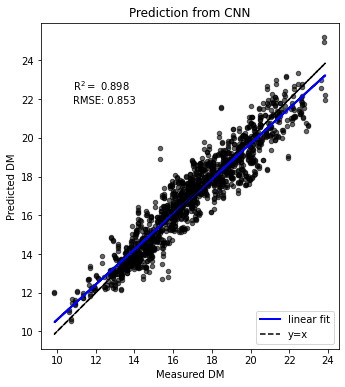

In [42]:
## Initialize a model with the best found hyperparameters
model_cnn = create_model(45, 0.015)

## Load the weights of the pre-trained / saved corresponding model
## load pre-computed model weights into model_cnn
model_cnn.load_weights("regression_pre_trained/study_trial=156.h5")

## Compute metrics for CAL, TUNING and TEST sets
y_cal_pred3 = model_cnn.predict(x_cal_scaled_col)
y_tuning_pred3 = model_cnn.predict(x_tuning_scaled_col)
y_test_pred3  = model_cnn.predict(x_test_scaled_col)


## Print some metrics and append to list
plot_prediction(x_cal_scaled_col, y_cal, x_tuning_scaled_col, y_tuning, x_test_scaled_col, y_test, y_cal_pred3, y_tuning_pred3, y_test_pred3, savefig=False, figname='prediction_base_model1.png')

Alternatively one my want to load the pre-computed study and analyse it directly by exploring the information logged by this Optuna object.

In [60]:
loaded_study = optuna.load_study(study_name="study", storage="sqlite:///study.db")

Loaded study can now be probed and the relevant variables listed:

In [63]:
print('Best trial:',loaded_study.best_trial.number)
print('Best trial value:',loaded_study.best_trial.value)
print('Best trial hyperparameters:',loaded_study.best_trial.params)

Best trial: 156
Best trial value: 0.3480654454179174
Best trial hyperparameters: {'batch_size': 128, 'filter_size': 45, 'reg_beta': 0.015}


Optuna provides a several visualization options that can help access the quality of the optimization process. Here is one example of the optmization history

C:\Users\dmcp\Miniconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



(-20.0, 500.0)

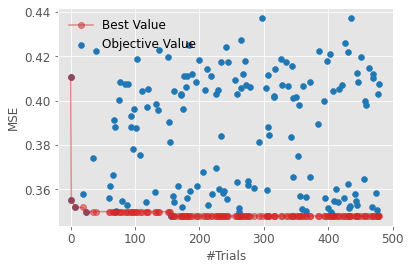

In [66]:
optuna.visualization.matplotlib.plot_optimization_history(loaded_study)
plt.title('')
plt.ylabel('MSE')
plt.legend(frameon=False)
plt.xlim(-20,500)

D. Passos and P. Mishra 2021